In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import squarify
import rpy2.robjects as ro
import matplotlib

from collections import defaultdict
from copy import deepcopy
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

In [3]:
src_path: str = "/home/uziel/Development/goi-strat/src"
sys.path.insert(0, src_path)

In [4]:
from r_wrappers.utils import rpy2_df_to_pd_df, pd_df_to_rpy2_df
from r_wrappers.deseq2 import vst_transform
from components.functional_analysis.orgdb import OrgDB

org_db = OrgDB("Homo sapiens")
root = Path("/mnt/d/phd_data/")
pcta_wcdt_root = root.joinpath("PCTA-WCDT_FOLH1")
tcga_root = root.joinpath("TCGA-PRAD_MethArray_FOLH1")
wcdt_root = root.joinpath("WCDT-MCRPC_FOLH1")
PALETTE_STR: str = "coolwarm"  # coolwarm or flare

sns.set_theme(style="whitegrid", palette=PALETTE_STR)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Ubuntu Mono"
plt.rcParams["font.monospace"] = "Ubuntu Mono"

In [5]:
pcta_wcdt_figs_path = pcta_wcdt_root.joinpath("manuscript_figures")
pcta_wcdt_figs_path.mkdir(parents=True, exist_ok=True)
pcta_wcdt_add_files_path = pcta_wcdt_root.joinpath("supplementary_files")
pcta_wcdt_add_files_path.mkdir(parents=True, exist_ok=True)

In [6]:
pcta_wcdt_annot_df = pd.read_csv(
    pcta_wcdt_root.joinpath("data").joinpath("samples_annotation_FOLH1.csv"),
    index_col=0,
)
tcga_annot_df = pd.read_csv(
    tcga_root.joinpath("data").joinpath("samples_annotation_FOLH1.csv"), index_col=0
)
wcdt_annot_df = pd.read_csv(
    wcdt_root.joinpath("data").joinpath("samples_annotation_FOLH1.csv"), index_col=0
)

## Figure 1: Workflow

A workflow schematic showing our method from start to finish. Kind of a graphical abstract, it must be visually attractive and contain few technical details. **This should give the reader an overview of the whole methodology.**


![Methodology Workflow](../docs/1_workflow.svg)


## Figure 2: Data

Focus on PCTA+WCDT (PCTA+), but mention that a subset of samples has DNA methylation or WGBS data available. **This should show a good summary of the data used in the study.**

1. (**A**) PCA of all samples (before batch correction)
2. (**B**) Treemap with dataset composition of PCTA+
3. (**C**) Treemap of tissue origin in metastatic samples
4. (**D**) PCA of all samples (after batch correction)
5. (**E**) PSMA levels of each group in a raincloud plot (prim)
6. (**F**) PSMA levels of each group in a raincloud plot (met)

In [7]:
with pd.ExcelWriter(pcta_wcdt_add_files_path / "supplementary_file_1.xlsx") as writer:
    pcta_wcdt_annot_df.to_excel(writer, sheet_name="1A. PCTA+ Annotations")
    tcga_annot_df.to_excel(writer, sheet_name="1B. TCGA-PRAD Annotations")
    wcdt_annot_df.to_excel(writer, sheet_name="1C. WCDT-MCRPC Annotations")

### 2A: PCA of all samples (before batch correction)

In [8]:
counts_df = pd.read_csv(
    root.joinpath("PCTA-WCDT").joinpath("data").joinpath("raw_counts.csv"), index_col=0
)
print(counts_df.shape)
counts_df_wo_batch_effects = pd.read_csv(
    root.joinpath("PCTA-WCDT")
    .joinpath("data")
    .joinpath("raw_counts_wo_batch_effects.csv"),
    index_col=0,
)
print(counts_df.shape)

(58341, 1202)
(58341, 1202)


In [9]:
common_samples = pcta_wcdt_annot_df.index.intersection(counts_df.columns)
annot_df_contrasts = pcta_wcdt_annot_df.loc[common_samples, :]
counts_df = counts_df.loc[:, common_samples]
counts_df_wo_batch_effects = counts_df_wo_batch_effects.loc[:, common_samples]

In [10]:
vst_df = rpy2_df_to_pd_df(
    vst_transform(
        ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df.loc[counts_df.mean(axis=1) > 1]))
    )
)
vst_wo_batch_effects_df = rpy2_df_to_pd_df(
    vst_transform(
        ro.r("as.matrix")(
            pd_df_to_rpy2_df(
                counts_df_wo_batch_effects.loc[
                    counts_df_wo_batch_effects.mean(axis=1) > 10
                ]
            )
        )
    )
)

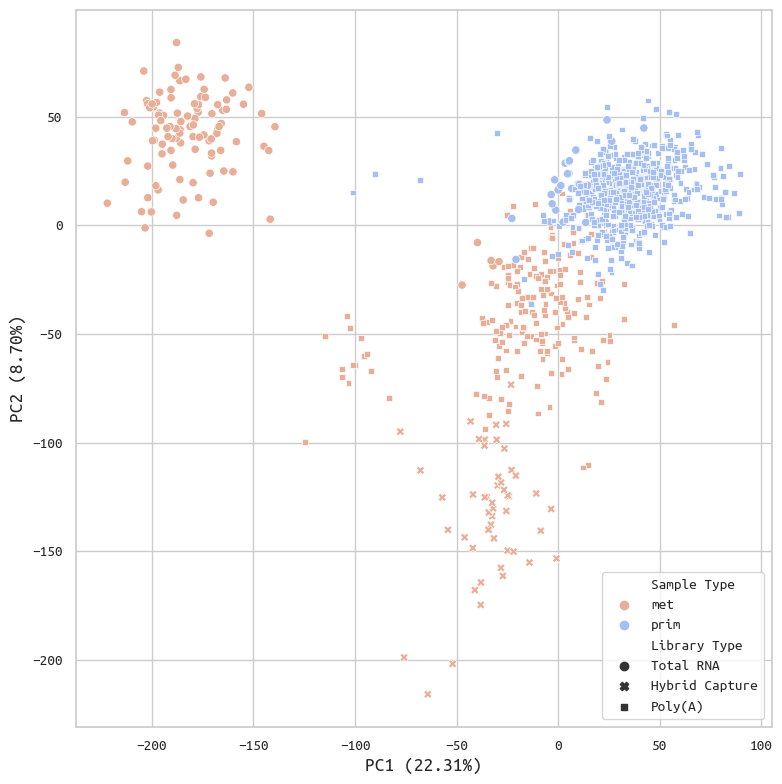

In [11]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

pca = PCA(n_components=2)
pca_comps = pca.fit_transform(vst_df.transpose().values)
palette = {
    "norm": "#9ACD32",
    "prim": "#A6BFF2",
    "met": "#E9AE97",
}

annot_df_contrasts["Sample Type"] = annot_df_contrasts["sample_type"]
annot_df_contrasts["Library Type"] = annot_df_contrasts["library_type"].map(
    {"total_rna": "Total RNA", "hybrid_capture": "Hybrid Capture", "poly_a": "Poly(A)"}
)
sns.scatterplot(
    x=pca_comps.T[0],
    y=pca_comps.T[1],
    hue=annot_df_contrasts["Sample Type"],
    palette=palette,
    style=annot_df_contrasts["Library Type"],
    ax=ax,
)

plt.legend(loc="lower right")
# plt.suptitle("PCA of PCTA+WCDT samples (before batch correction)", fontsize=18)
pca_variances = pca.explained_variance_ratio_
ax.set_xlabel(f"PC1 ({pca_variances[0] * 100:.2f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca_variances[1] * 100:.2f}%)", fontsize=14)
plt.tight_layout()
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2A_pca_before_combat.pdf"), bbox_inches="tight"
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2A_pca_before_combat.svg"), bbox_inches="tight"
)

### 2B: Treemap with dataset composition of PCTA+

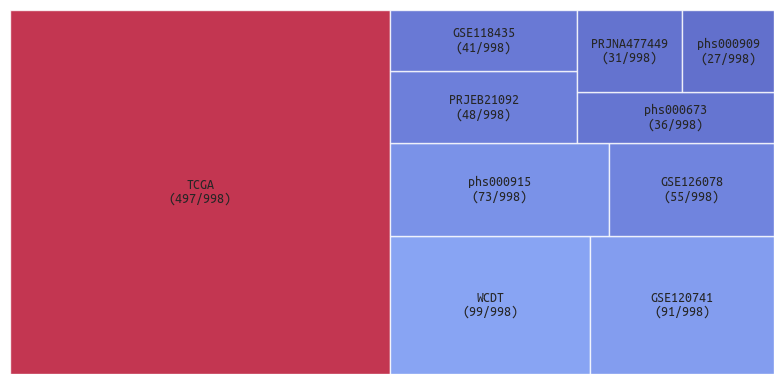

In [12]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = pcta_wcdt_annot_df
sizes = data["dataset"].value_counts()

labels = [f"{label}\n({value}/{len(data)})" for label, value in sizes.items()]

norm = matplotlib.colors.Normalize(vmin=sizes.values.min(), vmax=sizes.values.max())
cmap = sns.color_palette(PALETTE_STR, as_cmap=True)
colors = [cmap(norm(value)) for value in sizes.values]

squarify.plot(
    sizes=sizes.values,
    label=labels,
    alpha=0.8,
    color=colors,
    text_kwargs={"fontsize": 10},
)
# plt.title("PCTA+ dataset composition")
plt.axis("off")
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("2B_dataset_origin.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("2B_dataset_origin.svg"), bbox_inches="tight")

### 2C: Treemap of tissue origin in metastatic samples

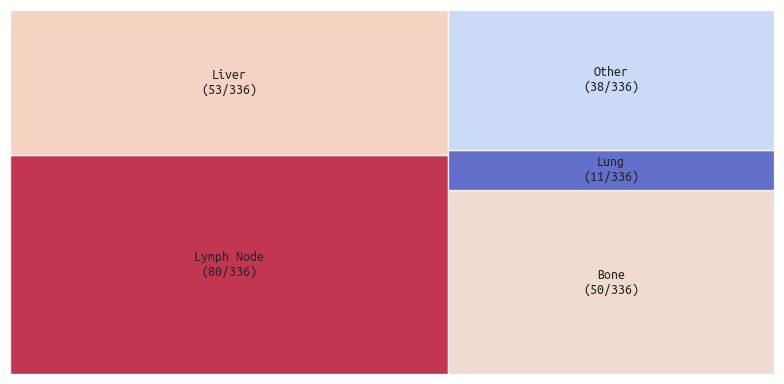

In [13]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = pcta_wcdt_annot_df[pcta_wcdt_annot_df["sample_type"] == "met"]
data.loc[:, "tumor_tissue_site"] = data["tumor_tissue_site"].apply(
    lambda x: x.replace("_", " ").title() if isinstance(x, str) else x
)
sizes = data["tumor_tissue_site"].value_counts()
sizes_clean = sizes.drop(sizes[sizes < 7].index)
sizes_clean["Other"] = sum(sizes[sizes < 7])

labels = [f"{label}\n({value}/{len(data)})" for label, value in sizes_clean.items()]

norm = matplotlib.colors.Normalize(
    vmin=sizes_clean.values.min(), vmax=sizes_clean.values.max()
)
cmap = sns.color_palette(PALETTE_STR, as_cmap=True)
colors = [cmap(norm(value)) for value in sizes_clean.values]

squarify.plot(
    sizes=sizes_clean.values,
    label=labels,
    alpha=0.8,
    color=colors,
    text_kwargs={"fontsize": 10},
)
# plt.title("Origin tissue site of metastatic samples in PCTA+")
plt.axis("off")
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("2C_tissue_origin.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("2C_tissue_origin.svg"), bbox_inches="tight")

### 2D: PCA of all samples (after batch correction)

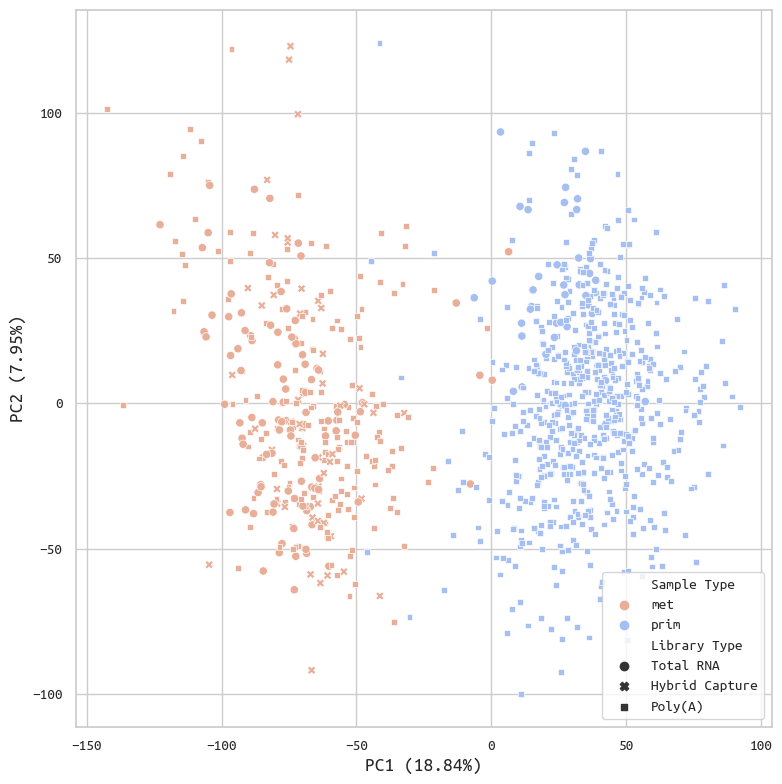

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)

pca = PCA(n_components=2)
pca_comps = pca.fit_transform(vst_wo_batch_effects_df.transpose().values)
palette = {
    "norm": "#9ACD32",
    "prim": "#A6BFF2",
    "met": "#E9AE97",
}
annot_df_contrasts["Sample Type"] = annot_df_contrasts["sample_type"]
annot_df_contrasts["Library Type"] = annot_df_contrasts["library_type"].map(
    {"total_rna": "Total RNA", "hybrid_capture": "Hybrid Capture", "poly_a": "Poly(A)"}
)
sns.scatterplot(
    x=pca_comps.T[0],
    y=pca_comps.T[1],
    hue=annot_df_contrasts["Sample Type"],
    palette=palette,
    style=annot_df_contrasts["Library Type"],
    ax=ax,
)

plt.legend(loc="lower right")
# plt.suptitle("PCA of PCTA+WCDT samples (after batch correction)", fontsize=18)
pca_variances = pca.explained_variance_ratio_
ax.set_xlabel(f"PC1 ({pca_variances[0] * 100:.2f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca_variances[1] * 100:.2f}%)", fontsize=14)
plt.tight_layout()
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2D_pca_after_combat.pdf"), bbox_inches="tight"
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2D_pca_after_combat.svg"), bbox_inches="tight"
)

### 2E: PSMA levels of each group in a raincloud plot (prim)

In [15]:
data_df = pcta_wcdt_annot_df[pcta_wcdt_annot_df["sample_type"] == "prim"]

data_x = []
folh1_levels = []
for folh1_level in ("high", "mid", "low"):
    x = data_df[data_df["FOLH1_level"] == folh1_level]["FOLH1_VST"]
    data_x.append(x)
    folh1_levels.append(folh1_level + f"\n({len(x)})")

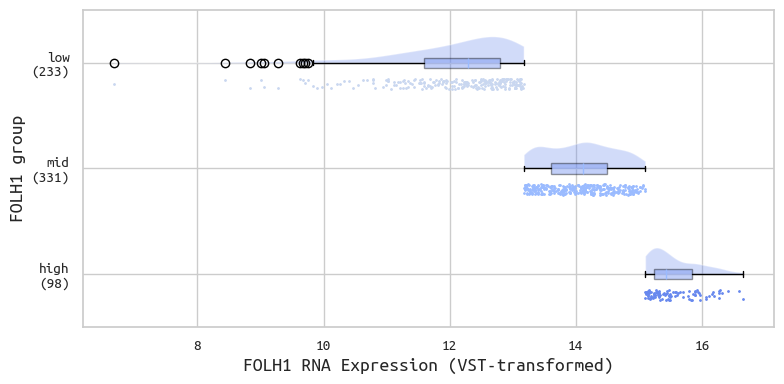

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True, vert=False, widths=0.1)

# Change to the desired color and add transparency
for patch in bp["boxes"]:
    # patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Violinplot data
vp = ax.violinplot(
    data_x,
    # points=500,
    showmeans=False,
    showextrema=False,
    showmedians=False,
    vert=False,
)

for idx, b in enumerate(vp["bodies"]):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])

    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(
        b.get_paths()[0].vertices[:, 1], idx + 1, idx + 2
    )

# Scatterplot data
for idx, features in enumerate(data_x):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + 0.8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-0.05, high=0.05, size=len(idxs))
    y = out
    plt.scatter(features, y, s=1)

plt.yticks(np.arange(1, len(folh1_levels) + 1, 1), folh1_levels)
plt.ylabel("FOLH1 group", fontsize=14)
plt.xlabel("FOLH1 RNA Expression (VST-transformed)", fontsize=14)
# plt.suptitle("Optimal stratification of primary samples in PCTA+", fontsize=18)
plt.tight_layout()
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2E_prim_psma_rainclouds.pdf"), bbox_inches="tight"
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2E_prim_psma_rainclouds.svg"), bbox_inches="tight"
)

### 2F: PSMA levels of each group in a raincloud plot (met)

In [17]:
data_df = pcta_wcdt_annot_df[pcta_wcdt_annot_df["sample_type"] == "met"]

data_x = []
folh1_levels = []
for folh1_level in ("high", "mid", "low"):
    x = data_df[data_df["FOLH1_level"] == folh1_level]["FOLH1_VST"]
    data_x.append(x)
    folh1_levels.append(folh1_level + f"\n({len(x)})")

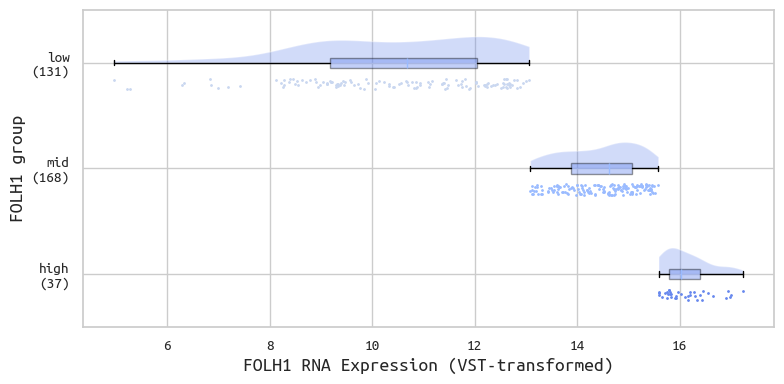

In [18]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True, vert=False, widths=0.1)

# Change to the desired color and add transparency
for patch in bp["boxes"]:
    # patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Violinplot data
vp = ax.violinplot(
    data_x,
    # points=500,
    showmeans=False,
    showextrema=False,
    showmedians=False,
    vert=False,
)

for idx, b in enumerate(vp["bodies"]):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])

    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(
        b.get_paths()[0].vertices[:, 1], idx + 1, idx + 2
    )

# Scatterplot data
for idx, features in enumerate(data_x):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + 0.8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-0.05, high=0.05, size=len(idxs))
    y = out
    plt.scatter(features, y, s=1)

plt.yticks(np.arange(1, len(folh1_levels) + 1, 1), folh1_levels)
plt.ylabel("FOLH1 group", fontsize=14)
plt.xlabel("FOLH1 RNA Expression (VST-transformed)", fontsize=14)
# plt.suptitle("Optimal stratification of metastatic samples in PCTA+", fontsize=18)
plt.tight_layout()

plt.savefig(
    pcta_wcdt_figs_path.joinpath("2F_met_psma_rainclouds.pdf"), bbox_inches="tight"
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("2F_met_psma_rainclouds.svg"), bbox_inches="tight"
)

## Figure 3: Differential analyses

This figure should summarize the gene sets obtained from D-GSVA and GSEA (DE & DM).

1. (**A**) Barplot of D-GSVA gene sets for category H (prim over/under)
2. (**B**) Barplot of D-GSVA gene sets for category H (met over/under)
3. (**C**) Starburst plot (prim)
4. (**D**) Barplot of GSEA (DE) gene sets for category H (prim over/under)
5. (**E**) Barplot of GSEA (DM) gene sets for category H (prim over/under)
6. (**F**) Starburst plot (met)
7. (**G**) Barplot of GSEA (DE) gene sets for category H (met over/under)
8. (**H**) Barplot of GSEA (DM) gene sets for category H (met over/under)

In [19]:
writer_2 = pd.ExcelWriter(pcta_wcdt_add_files_path / "supplementary_file_2.xlsx")

### 3A: Barplot of D-GSVA gene sets for category H (prim over/under)

In [20]:
dgsva_h_df = pd.read_csv(
    pcta_wcdt_root.joinpath("diff_gsva")
    .joinpath("H")
    .joinpath(
        "sample_type_met+prim_FOLH1_level_prim_high+prim_low_"
        "_prim_high_vs_prim_low_top_table_padj_0_05_all_0_0.csv"
    ),
    index_col=0,
)
dgsva_h_df.index = [
    idx.replace("HALLMARK_", "").replace("_", " ") for idx in dgsva_h_df.index
]

In [21]:
dgsva_h_df.to_excel(writer_2, sheet_name="2A. D-GSVA H (PRIM)")

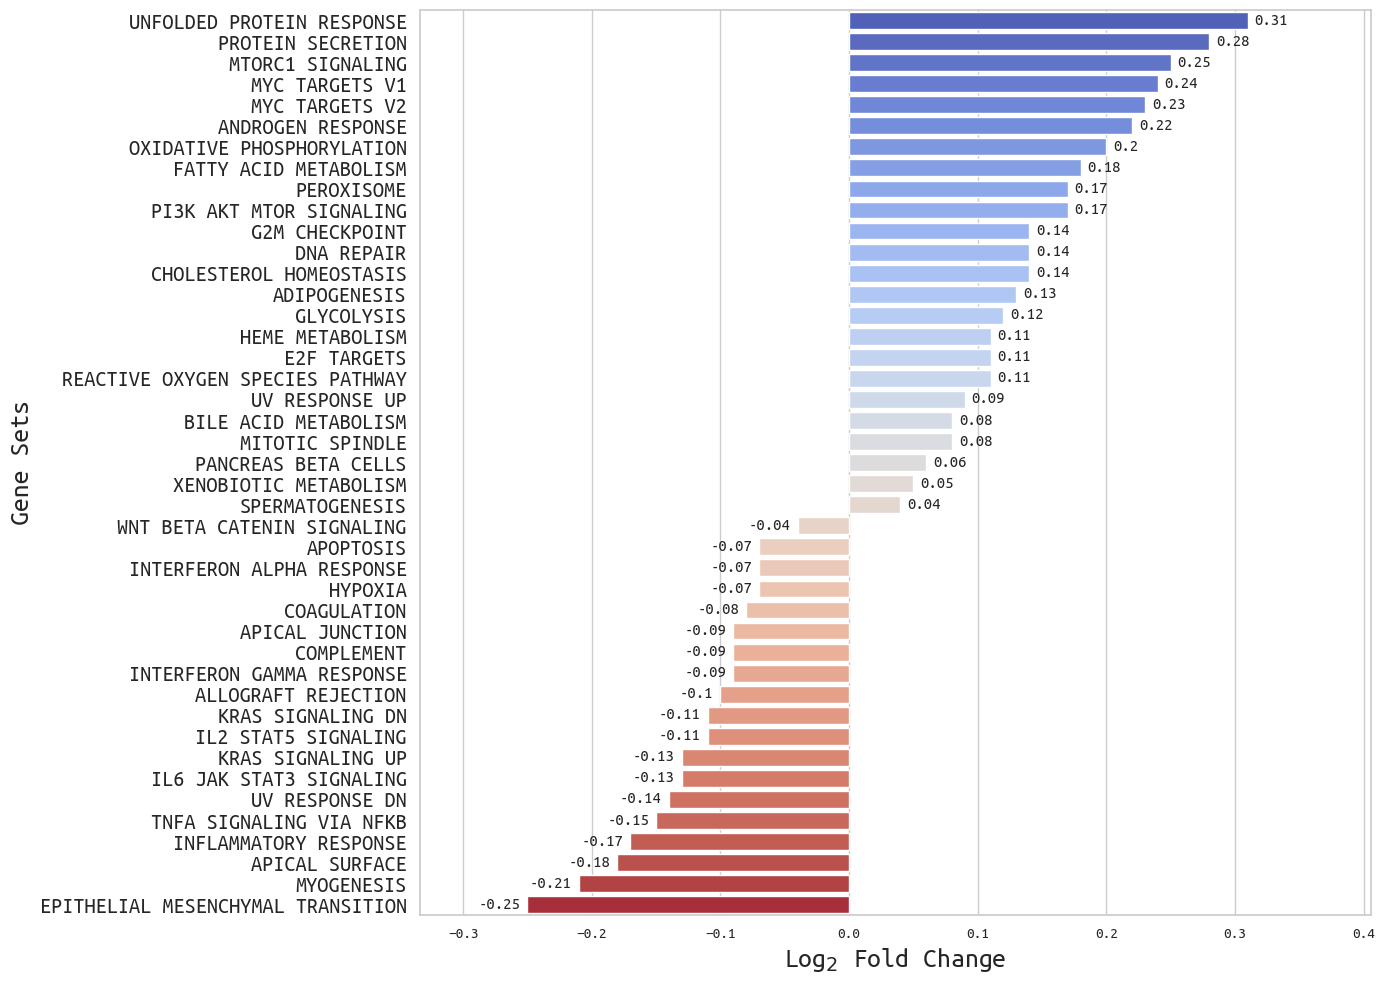

In [22]:
data = dgsva_h_df["log2FoldChange"].sort_values(ascending=False).round(2).to_frame()

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.barplot(data=data, x="log2FoldChange", y=data.index, palette=PALETTE_STR)
for container in ax.containers:
    ax.bar_label(container, padding=5)

ax.set_ylabel("Gene Sets", fontsize=20)
plt.yticks(fontsize=16)
ax.set_xlabel("Log$_2$ Fold Change", fontsize=20)
ax.set_xlim([ax.get_xlim()[0] * 1.2, ax.get_xlim()[1] * 1.2])
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3A_dgsva_h_prim.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3A_dgsva_h_prim.svg"), bbox_inches="tight")

### 3B: Barplot of D-GSVA gene sets for category H (met over/under)

In [23]:
dgsva_h_df = pd.read_csv(
    pcta_wcdt_root.joinpath("diff_gsva")
    .joinpath("H")
    .joinpath(
        "sample_type_met+prim_FOLH1_level_met_high+met_low_"
        "_met_high_vs_met_low_top_table_padj_0_05_all_0_0.csv"
    ),
    index_col=0,
)
dgsva_h_df.index = [
    idx.replace("HALLMARK_", "").replace("_", " ") for idx in dgsva_h_df.index
]

In [24]:
dgsva_h_df.to_excel(writer_2, sheet_name="2B. D-GSVA H (MET)")

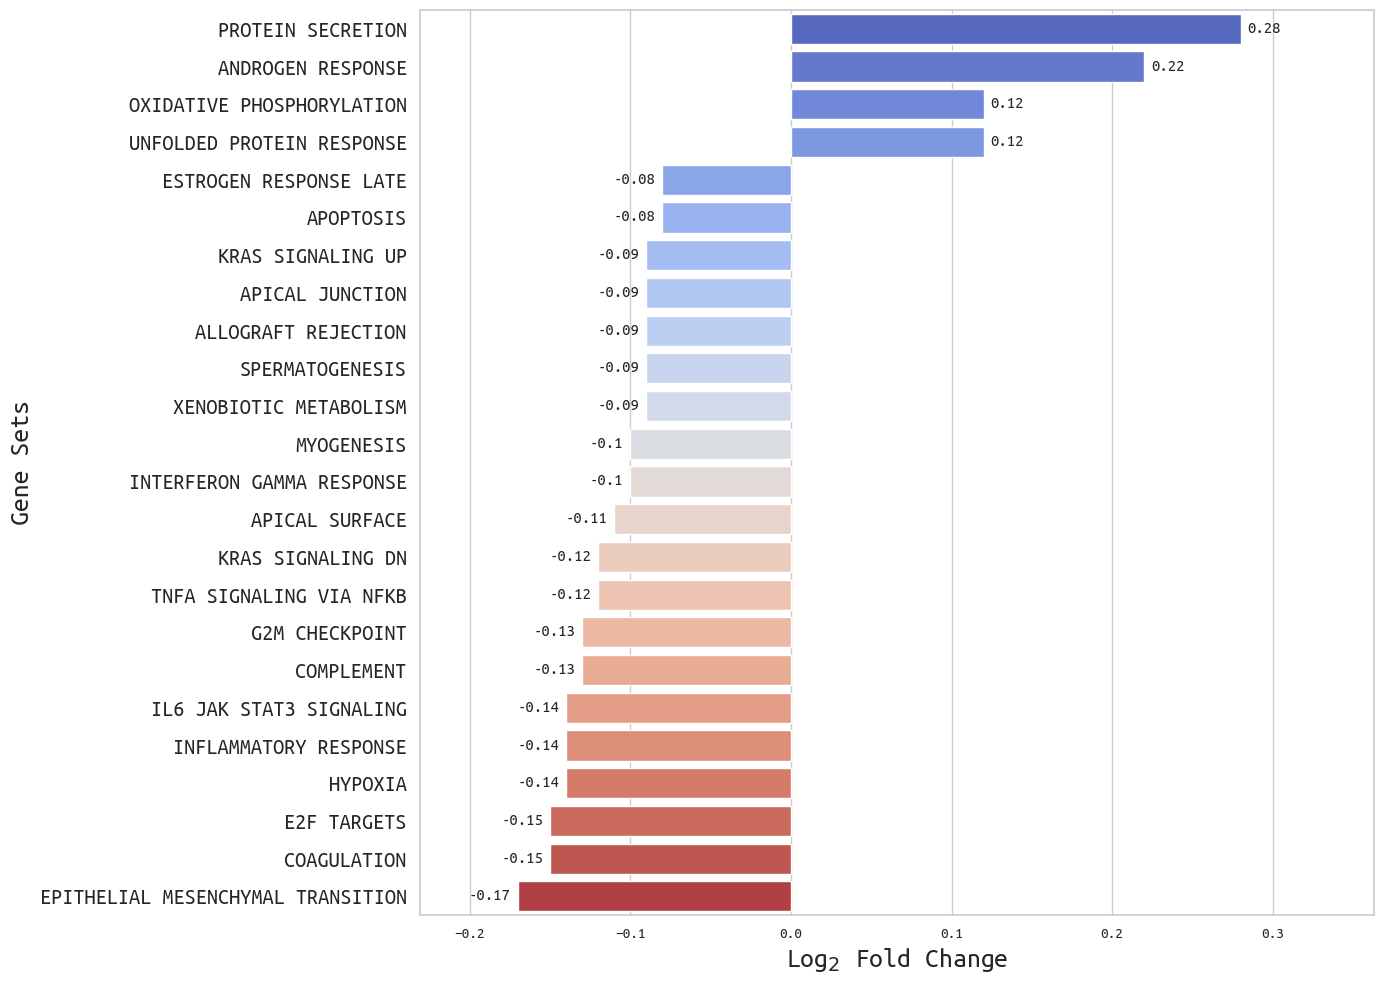

In [25]:
data = dgsva_h_df["log2FoldChange"].sort_values(ascending=False).round(2).to_frame()

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.barplot(data=data, x="log2FoldChange", y=data.index, palette=PALETTE_STR)
for container in ax.containers:
    ax.bar_label(container, padding=5)

ax.set_ylabel("Gene Sets", fontsize=20)
plt.yticks(fontsize=16)
ax.set_xlabel("Log$_2$ Fold Change", fontsize=20)
ax.set_xlim([ax.get_xlim()[0] * 1.2, ax.get_xlim()[1] * 1.2])
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3B_dgsva_h_met.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3B_dgsva_h_met.svg"), bbox_inches="tight")

### 3C: Starburst plot (prim)

In [26]:
label_colors = {
    "Not relevant": "gray",
    "Up regulated": "#94090D",
    "Up regulated & Hyper methylated": "#450003",
    "Up regulated & Hypo methylated": "#FF1D23",
    "Down regulated": "#A7E7F6",
    "Down regulated & Hyper methylated": "#318EAD",
    "Down regulated & Hypo methylated": "#225A76",
    "Hyper methylated": "#F06E19",
    "Hypo methylated": "#3FCEF6",
}

In [27]:
df = pd.read_csv(
    (
        pcta_wcdt_root.joinpath("deseq2").joinpath(
            "sample_type_met+prim_FOLH1_level_prim_high+prim_low__"
            "prim_high_vs_prim_low_deseq_results_unique.csv"
        )
    ),
    index_col=0,
).set_index("SYMBOL")

In [28]:
diff_expr_df = pd.read_csv(
    (
        pcta_wcdt_root.joinpath("deseq2").joinpath(
            "sample_type_met+prim_FOLH1_level_prim_high+prim_low__"
            "prim_high_vs_prim_low_deseq_results_unique.csv"
        )
    ),
    index_col=0,
).set_index("SYMBOL")
diff_expr_df = diff_expr_df[diff_expr_df["padj"] < 0.05]

diff_meth_df = (
    pd.read_csv(
        (
            tcga_root.joinpath("minfi").joinpath(
                "sample_type_prim_FOLH1_level_prim_high+prim_low__"
                "diff_meth_probes_noob_quantile_top_table_prim_high_vs_prim_low_"
                "wrt_mean_diff_0_0_hg38_genes_promoters.csv"
            )
        ),
        index_col=0,
    )
    .replace("NA_character_", np.nan)
    .dropna(subset=["annot.symbol"])
)
diff_meth_df = (
    diff_meth_df[diff_meth_df["adj.P.Val"] < 0.05]
    .groupby("annot.symbol")
    .mean(numeric_only=True)
    .rename_axis("SYMBOL")
)

In [29]:
common_genes = diff_expr_df.index.intersection(diff_meth_df.index)
print(len(common_genes))
starburst_df = pd.DataFrame()
starburst_df["expr_lfc"] = diff_expr_df.loc[common_genes, "log2FoldChange"]
starburst_df["meth_lfc"] = diff_meth_df.loc[common_genes, "logFC"]

6141


In [30]:
starburst_df.loc[
    (abs(starburst_df["expr_lfc"]) < 1) & (abs(starburst_df["meth_lfc"]) < 1), "label"
] = "Not relevant"

starburst_df.loc[
    (starburst_df["expr_lfc"] > 1) & (abs(starburst_df["meth_lfc"]) < 1), "label"
] = "Up regulated"
starburst_df.loc[
    (starburst_df["expr_lfc"] > 1) & (starburst_df["meth_lfc"] > 1), "label"
] = "Up regulated & Hyper methylated"
starburst_df.loc[
    (starburst_df["expr_lfc"] > 1) & (starburst_df["meth_lfc"] < -1), "label"
] = "Up regulated & Hypo methylated"

starburst_df.loc[
    (starburst_df["expr_lfc"] < -1) & (abs(starburst_df["meth_lfc"]) < 1), "label"
] = "Down regulated"
starburst_df.loc[
    (starburst_df["expr_lfc"] < -1) & (starburst_df["meth_lfc"] > 1), "label"
] = "Down regulated & Hyper methylated"
starburst_df.loc[
    (starburst_df["expr_lfc"] < -1) & (starburst_df["meth_lfc"] < -1), "label"
] = "Down regulated & Hypo methylated"

starburst_df.loc[
    (abs(starburst_df["expr_lfc"]) < 1) & (starburst_df["meth_lfc"] > 1), "label"
] = "Hyper methylated"
starburst_df.loc[
    (abs(starburst_df["expr_lfc"]) < 1) & (starburst_df["meth_lfc"] < -1), "label"
] = "Hypo methylated"

In [31]:
starburst_df.to_excel(writer_2, sheet_name="2C. Starburst (PRIM)")

In [32]:
prim_label_colors = {
    k: v for k, v in label_colors.items() if k in starburst_df["label"].unique()
}

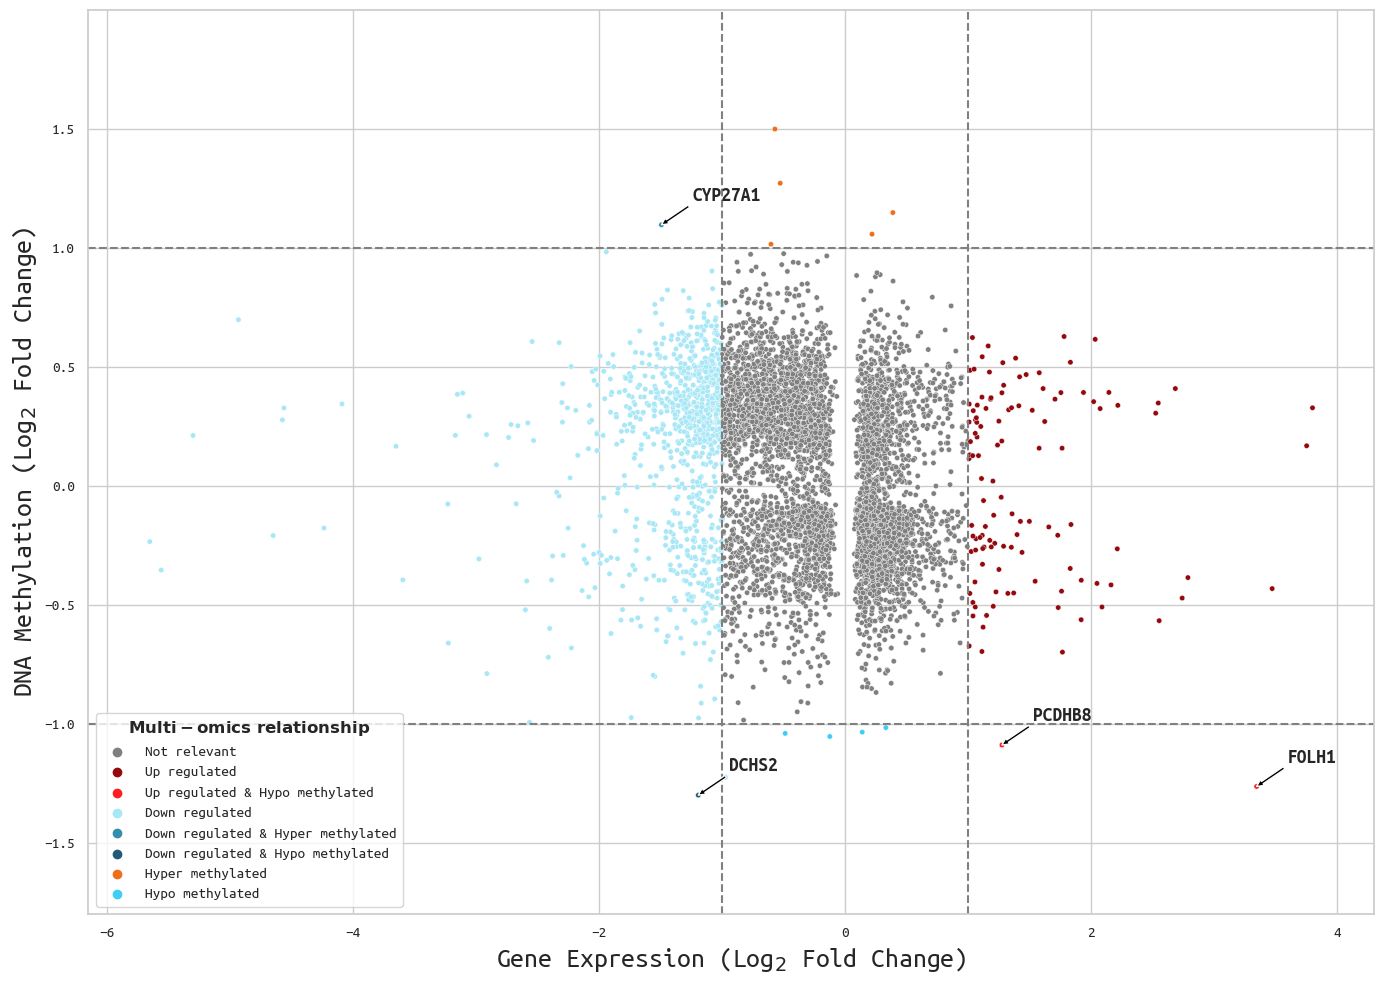

In [33]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.scatterplot(
    data=starburst_df,
    x="expr_lfc",
    y="meth_lfc",
    hue="label",
    palette=prim_label_colors,
    hue_order=prim_label_colors.keys(),
    ax=ax,
    s=15,
)
highlight_labels = (
    "Up regulated & Hyper methylated",
    "Up regulated & Hypo methylated",
    "Down regulated & Hyper methylated",
    "Down regulated & Hypo methylated",
)

labels_counter = dict()
labels_text_y = defaultdict(lambda: 99)
for gene, meta in starburst_df.sort_values(
    ["expr_lfc", "meth_lfc"], key=abs, ascending=False
).iterrows():
    label = meta["label"]
    if label in highlight_labels:
        if labels_counter.get(label, 0) == 5:
            continue
        labels_counter[label] = labels_counter.get(label, 0) + 1

        text_y_new = meta["meth_lfc"] + 0.1
        text_y_new = (
            text_y_new
            if abs(labels_text_y[label] - text_y_new) > 0.1
            else (labels_text_y[label] + 0.1)
        )
        labels_text_y[label] = text_y_new

        plt.annotate(
            gene,
            xy=(meta["expr_lfc"], meta["meth_lfc"]),
            xytext=(meta["expr_lfc"] + 0.25, text_y_new),
            arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
            fontsize=14,
            weight="semibold",
        )

ymin, ymax = (
    starburst_df["meth_lfc"].min() - 0.5,
    starburst_df["meth_lfc"].max() + 0.5,
)
plt.ylim((ymin, ymax))

xmin, xmax = (
    starburst_df["expr_lfc"].min() - 0.5,
    starburst_df["expr_lfc"].max() + 0.5,
)
plt.xlim((xmin, xmax))

# vertical lines
plt.vlines(
    1,
    ymin=ymin,
    ymax=ymax,
    colors="grey",
    linestyles="dashed",
)
plt.vlines(
    -1,
    ymin=ymin,
    ymax=ymax,
    colors="grey",
    linestyles="dashed",
)

# horizontal lines
plt.hlines(
    1,
    xmin=xmin,
    xmax=xmax,
    colors="grey",
    linestyles="dashed",
)
plt.hlines(
    -1,
    xmin=xmin,
    xmax=xmax,
    colors="grey",
    linestyles="dashed",
)

# axis labels
plt.xlabel("Gene Expression (Log$_2$ Fold Change)", fontsize=20)
plt.ylabel("DNA Methylation (Log$_2$ Fold Change)", fontsize=20)
plt.legend(title=r"$\bf Multi-omics\ relationship$", loc="lower left")
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3C_prim_starburst.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3C_prim_starburst.svg"), bbox_inches="tight")

### 3D: Barplot of GSEA (DE) gene sets for category H (prim over/under)

In [34]:
gsea_h_df = pd.read_csv(
    pcta_wcdt_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(
        "sample_type_met+prim_FOLH1_level_prim_high+prim_low_"
        "_prim_high_vs_prim_low_gsea_H.csv"
    ),
    index_col=0,
)
gsea_h_df.index = [
    idx.replace("HALLMARK_", "").replace("_", " ") for idx in gsea_h_df.index
]

In [35]:
gsea_h_df.to_excel(writer_2, sheet_name="2D. GSEA DE H (PRIM)")

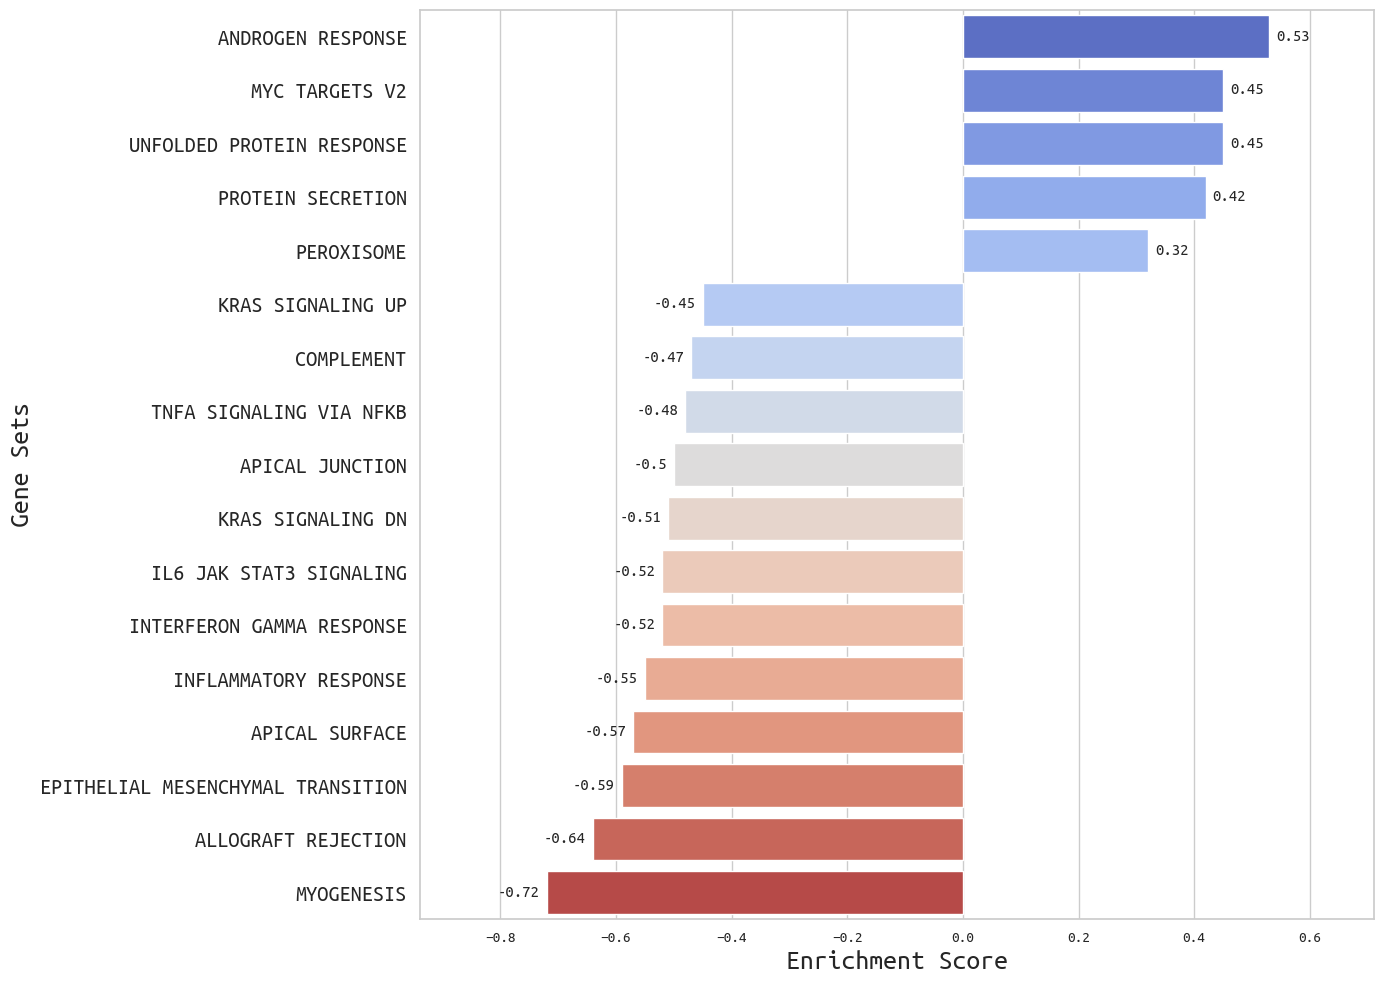

In [36]:
data = gsea_h_df["enrichmentScore"].sort_values(ascending=False).round(2).to_frame()

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.barplot(data=data, x="enrichmentScore", y=data.index, palette=PALETTE_STR)
for container in ax.containers:
    ax.bar_label(container, padding=5)

ax.set_ylabel("Gene Sets", fontsize=20)
plt.yticks(fontsize=16)
ax.set_xlabel("Enrichment Score", fontsize=20)
ax.set_xlim([ax.get_xlim()[0] * 1.2, ax.get_xlim()[1] * 1.2])
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3D_gsea_de_h_prim.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3D_gsea_de_h_prim.svg"), bbox_inches="tight")

### 3E: Barplot of GSEA (DM) gene sets for category H (prim over/under)

In [37]:
gsea_h_df = pd.read_csv(
    tcga_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(
        "sample_type_prim_FOLH1_level_prim_high+prim_low_"
        "_diff_meth_probes_noob_quantile_top_table_prim_high_vs_prim_low_"
        "wrt_mean_diff_0_0_hg38_genes_promoters_gsea_H.csv"
    ),
    index_col=0,
)
gsea_h_df.index = [
    idx.replace("HALLMARK_", "").replace("_", " ") for idx in gsea_h_df.index
]

In [38]:
gsea_h_df.to_excel(writer_2, sheet_name="2E. GSEA DM H (PRIM)")

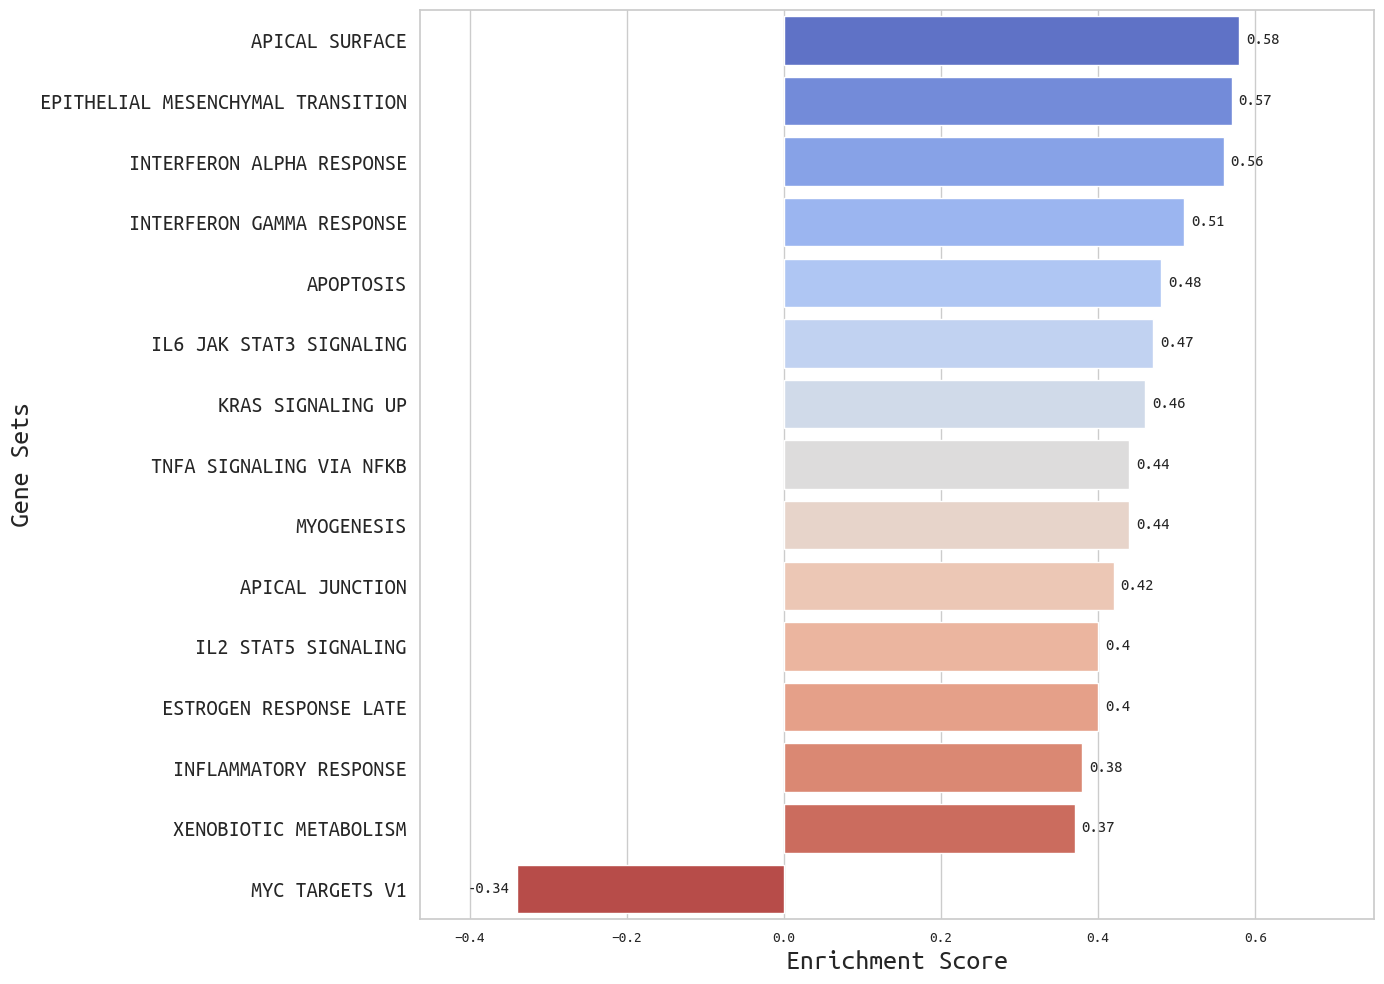

In [39]:
data = gsea_h_df["enrichmentScore"].sort_values(ascending=False).round(2).to_frame()

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.barplot(data=data, x="enrichmentScore", y=data.index, palette=PALETTE_STR)
for container in ax.containers:
    ax.bar_label(container, padding=5)

ax.set_ylabel("Gene Sets", fontsize=20)
plt.yticks(fontsize=16)
ax.set_xlabel("Enrichment Score", fontsize=20)
ax.set_xlim([ax.get_xlim()[0] * 1.2, ax.get_xlim()[1] * 1.2])
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3E_gsea_dm_h_prim.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3E_gsea_dm_h_prim.svg"), bbox_inches="tight")

### 3F: Starburst plot (met)

In [40]:
diff_expr_df = pd.read_csv(
    (
        pcta_wcdt_root.joinpath("deseq2").joinpath(
            "sample_type_met+prim_FOLH1_level_met_high+met_low__"
            "met_high_vs_met_low_deseq_results_unique.csv"
        )
    ),
    index_col=0,
).set_index("SYMBOL")
diff_expr_df = diff_expr_df[diff_expr_df["padj"] < 0.05]

diff_meth_df = (
    pd.read_csv(
        (
            wcdt_root.joinpath("methylkit").joinpath(
                "sample_type_met_FOLH1_level_met_high+met_low__"
                "diff_meth_met_high_vs_met_low_ann_genes_hg38_genes_promoters.csv"
            )
        ),
        index_col=0,
    )
    .replace("NA_character_", np.nan)
    .dropna(subset=["annot.symbol"])
)
diff_meth_df = (
    diff_meth_df[diff_meth_df["qvalue"] < 0.05]
    .groupby("annot.symbol")
    .mean(numeric_only=True)
    .rename_axis("SYMBOL")
)

In [41]:
common_genes = diff_expr_df.index.intersection(diff_meth_df.index)
print(len(common_genes))
starburst_df = pd.DataFrame()
starburst_df["expr_lfc"] = diff_expr_df.loc[common_genes, "log2FoldChange"]
starburst_df["meth_diff"] = diff_meth_df.loc[common_genes, "meth.diff"]

6608


In [42]:
meth_diff_th = 15

In [43]:
starburst_df.loc[
    (abs(starburst_df["expr_lfc"]) < 1)
    & (abs(starburst_df["meth_diff"]) < meth_diff_th),
    "label",
] = "Not relevant"

starburst_df.loc[
    (starburst_df["expr_lfc"] > 1) & (abs(starburst_df["meth_diff"]) < meth_diff_th),
    "label",
] = "Up regulated"
starburst_df.loc[
    (starburst_df["expr_lfc"] > 1) & (starburst_df["meth_diff"] > meth_diff_th), "label"
] = "Up regulated & Hyper methylated"
starburst_df.loc[
    (starburst_df["expr_lfc"] > 1) & (starburst_df["meth_diff"] < -meth_diff_th),
    "label",
] = "Up regulated & Hypo methylated"

starburst_df.loc[
    (starburst_df["expr_lfc"] < -1) & (abs(starburst_df["meth_diff"]) < meth_diff_th),
    "label",
] = "Down regulated"
starburst_df.loc[
    (starburst_df["expr_lfc"] < -1) & (starburst_df["meth_diff"] > meth_diff_th),
    "label",
] = "Down regulated & Hyper methylated"
starburst_df.loc[
    (starburst_df["expr_lfc"] < -1) & (starburst_df["meth_diff"] < -meth_diff_th),
    "label",
] = "Down regulated & Hypo methylated"

starburst_df.loc[
    (abs(starburst_df["expr_lfc"]) < 1) & (starburst_df["meth_diff"] > meth_diff_th),
    "label",
] = "Hyper methylated"
starburst_df.loc[
    (abs(starburst_df["expr_lfc"]) < 1) & (starburst_df["meth_diff"] < -meth_diff_th),
    "label",
] = "Hypo methylated"

In [44]:
starburst_df.to_excel(writer_2, sheet_name="2D. Starburst (MET)")

In [45]:
met_label_colors = {
    k: v for k, v in label_colors.items() if k in starburst_df["label"].unique()
}

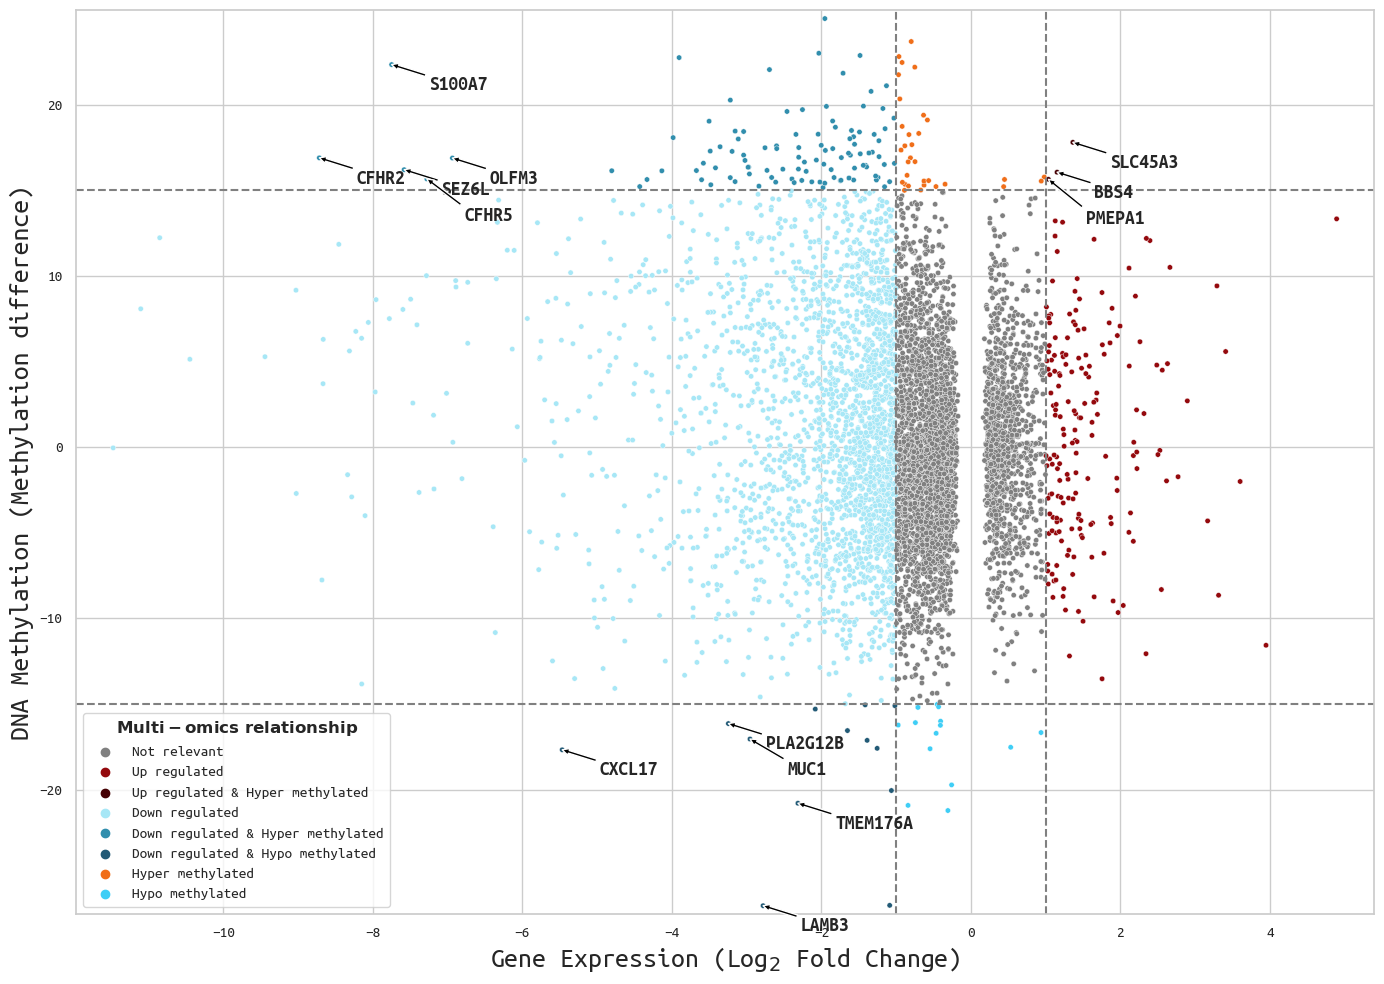

In [46]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.scatterplot(
    data=starburst_df,
    x="expr_lfc",
    y="meth_diff",
    hue="label",
    palette=met_label_colors,
    hue_order=met_label_colors.keys(),
    ax=ax,
    s=15,
)
highlight_labels = (
    "Up regulated & Hyper methylated",
    "Up regulated & Hypo methylated",
    "Down regulated & Hyper methylated",
    "Down regulated & Hypo methylated",
)

labels_counter = dict()
labels_text_y = defaultdict(lambda: 99)
for gene, meta in starburst_df.sort_values(
    ["expr_lfc", "meth_diff"], key=abs, ascending=False
).iterrows():
    label = meta["label"]
    if label in highlight_labels:
        if labels_counter.get(label, 0) == 5:
            continue
        labels_counter[label] = labels_counter.get(label, 0) + 1

        text_y_new = meta["meth_diff"] - 1.5
        text_y_new = (
            text_y_new
            if abs(labels_text_y[label] - text_y_new) > 1.5
            else (labels_text_y[label] - 1.5)
        )
        labels_text_y[label] = text_y_new

        plt.annotate(
            gene,
            xy=(meta["expr_lfc"], meta["meth_diff"]),
            xytext=(meta["expr_lfc"] + 0.5, text_y_new),
            arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
            fontsize=14,
            weight="semibold",
        )

ymin, ymax = (
    starburst_df["meth_diff"].min() - 0.5,
    starburst_df["meth_diff"].max() + 0.5,
)
plt.ylim((ymin, ymax))

xmin, xmax = (
    starburst_df["expr_lfc"].min() - 0.5,
    starburst_df["expr_lfc"].max() + 0.5,
)
plt.xlim((xmin, xmax))

# vertical lines
plt.vlines(
    1,
    ymin=ymin,
    ymax=ymax,
    colors="grey",
    linestyles="dashed",
)
plt.vlines(
    -1,
    ymin=ymin,
    ymax=ymax,
    colors="grey",
    linestyles="dashed",
)

# horizontal lines
plt.hlines(
    meth_diff_th,
    xmin=xmin,
    xmax=xmax,
    colors="grey",
    linestyles="dashed",
)
plt.hlines(
    -meth_diff_th,
    xmin=xmin,
    xmax=xmax,
    colors="grey",
    linestyles="dashed",
)

# axis labels
plt.xlabel("Gene Expression (Log$_2$ Fold Change)", fontsize=20)
plt.ylabel("DNA Methylation (Methylation difference)", fontsize=20)
plt.legend(title=r"$\bf Multi-omics\ relationship$", loc="lower left")
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3F_met_starburst.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3F_met_starburst.svg"), bbox_inches="tight")

### 3G: Barplot of GSEA (DE) gene sets for category H (met over/under)

In [47]:
gsea_h_df = pd.read_csv(
    pcta_wcdt_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(
        "sample_type_met+prim_FOLH1_level_met_high+met_low_"
        "_met_high_vs_met_low_gsea_H.csv"
    ),
    index_col=0,
)
gsea_h_df.index = [
    idx.replace("HALLMARK_", "").replace("_", " ") for idx in gsea_h_df.index
]

In [48]:
gsea_h_df.to_excel(writer_2, sheet_name="2G. GSEA DE H (MET)")

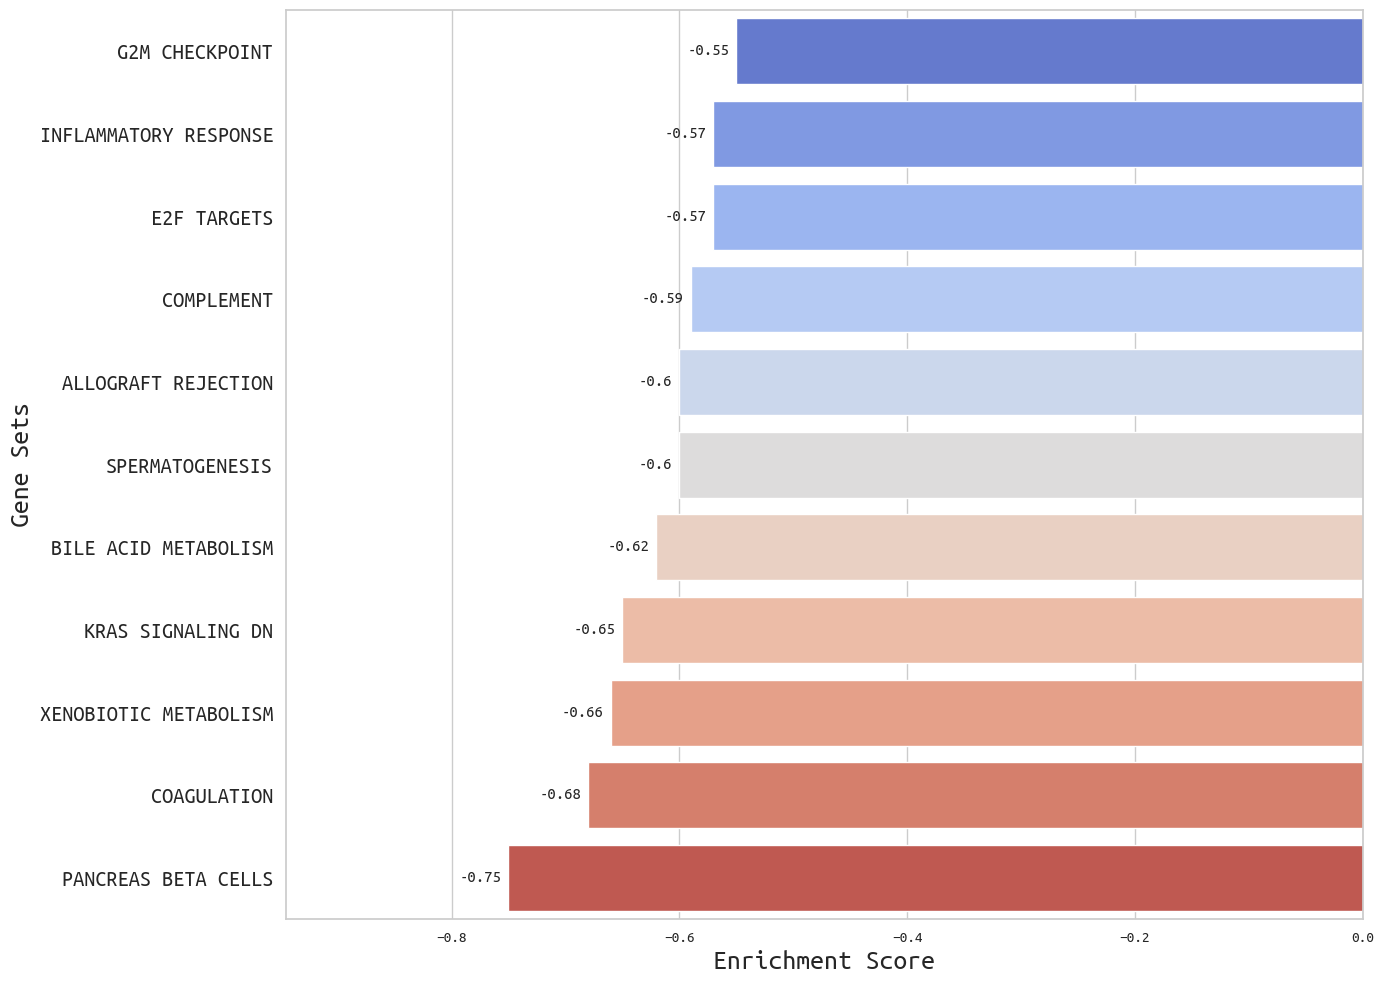

In [49]:
data = gsea_h_df["enrichmentScore"].sort_values(ascending=False).round(2).to_frame()

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

ax = sns.barplot(data=data, x="enrichmentScore", y=data.index, palette=PALETTE_STR)
for container in ax.containers:
    ax.bar_label(container, padding=5)

ax.set_ylabel("Gene Sets", fontsize=20)
plt.yticks(fontsize=16)
ax.set_xlabel("Enrichment Score", fontsize=20)
ax.set_xlim([ax.get_xlim()[0] * 1.2, ax.get_xlim()[1] * 1.2])
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("3G_gsea_de_h_met.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("3G_gsea_de_h_met.svg"), bbox_inches="tight")

### 3H: Barplot of GSEA (DM) gene sets for category H (met over/under)

**No results available!**

In [50]:
writer_2.close()

## Figure 4: Identifying PSMA protein community

This figure summarizes the sets of top genes found and the PPI network analysis.

1. (**A**) Jointplot of z-scores vs. log2 fold changes of DEGs (prim over)
2. (**B**) Jointplot of z-scores vs. log2 fold changes of DMRs (prim over)
3. (**C**) Jointplot of z-scores vs. log2 fold changes of DEGs (prim under)
4. (**D**) Jointplot of z-scores vs. log2 fold changes of DMRs (prim under)
5. (**E**) Jointplot of z-scores vs. log2 fold changes of DEGs (met over)
6. (**F**) Jointplot of z-scores vs. log2 fold changes of DMRs (met over)
7. (**G**) Jointplot of z-scores vs. log2 fold changes of DEGs (met under)
8. (**H**) Jointplot of z-scores vs. log2 fold changes of DMRs (met under)

In [51]:
writer_3 = pd.ExcelWriter(pcta_wcdt_add_files_path / "supplementary_file_3.xlsx")

In [52]:
ymin, ymax = (-1, 12)
xmin, xmax = (-8, 8)

### 4A. Jointplot of z-scores vs. log2 fold changes of DEGs (prim over)

In [53]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)
print(top_genes_df.shape)

(40755, 17)


In [54]:
top_genes_df.to_excel(writer_3, sheet_name="3A. Top genes stats (PRIM over)")

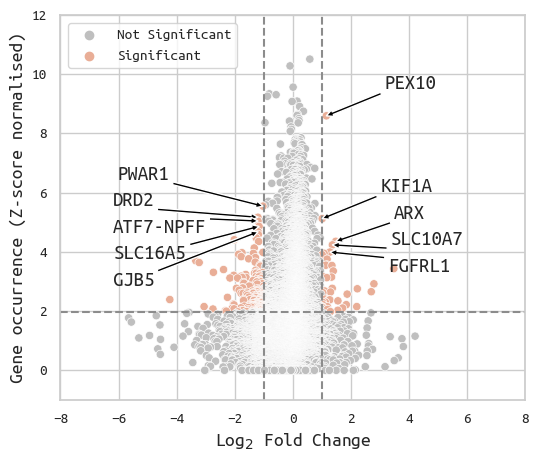

In [55]:
x, y, hue = ["diff_expr_log2FoldChange", "mean_z_score", "Statistical significance"]
expr_scatter_df = top_genes_df[[x, y]].dropna()

expr_scatter_df[hue] = "Significant"
expr_scatter_df.loc[expr_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
expr_scatter_df.loc[abs(expr_scatter_df[x]) < 1, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=expr_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] > 1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] < -1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 2, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 5, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel(r"Log$_2$ Fold Change", fontsize=14)
plt.legend(loc="upper left")
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4A_jointplot_diff_expr_prim_over.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4A_jointplot_diff_expr_prim_over.svg"),
    bbox_inches="tight",
)

### 4B. Jointplot of z-scores vs. log2 fold changes of DMRs (prim over)

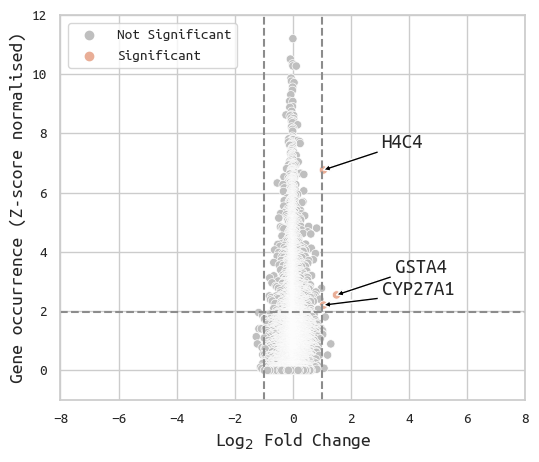

In [56]:
x, y, hue = ["diff_meth_promoters_logFC", "mean_z_score", "Statistical significance"]
meth_scatter_df = top_genes_df[[x, y]].dropna()

meth_scatter_df[hue] = "Significant"
meth_scatter_df.loc[meth_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
meth_scatter_df.loc[abs(meth_scatter_df[x]) < 1, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=meth_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] > 1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] < -1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.75
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.75
        else (text_y := text_y - 0.75)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 2, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.75
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.75
        else (text_y := text_y - 0.75)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 3, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel(r"Log$_2$ Fold Change", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4B_jointplot_diff_meth_prim_over.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4B_jointplot_diff_meth_prim_over.svg"),
    bbox_inches="tight",
)

### 4C. Jointplot of z-scores vs. log2 fold changes of DEGs (prim under)

In [57]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)
print(top_genes_df.shape)

(40755, 17)


In [58]:
top_genes_df.to_excel(writer_3, sheet_name="3B. Top genes stats (PRIM under)")

/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


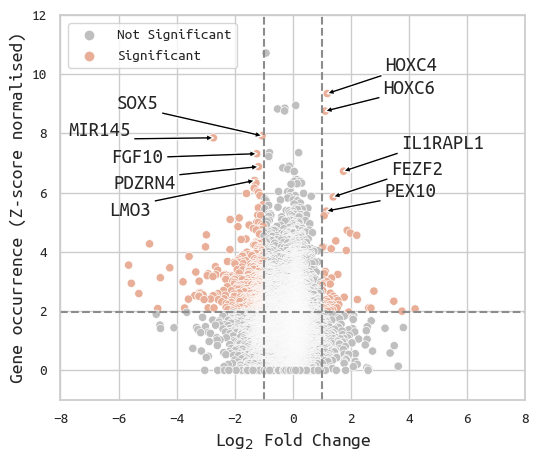

In [59]:
x, y, hue = ["diff_expr_log2FoldChange", "mean_z_score", "Statistical significance"]
expr_scatter_df = top_genes_df[[x, y]].dropna()

expr_scatter_df[hue] = "Significant"
expr_scatter_df.loc[expr_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
expr_scatter_df.loc[abs(expr_scatter_df[x]) < 1, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=expr_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] > 1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] < -1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.75
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.75
        else (text_y := text_y - 0.75)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 2, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 5, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel(r"Log$_2$ Fold Change", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4C_jointplot_diff_expr_prim_under.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4C_jointplot_diff_expr_prim_under.svg"),
    bbox_inches="tight",
)

### 4D. Jointplot of z-scores vs. log2 fold changes of DMRs (prim under)

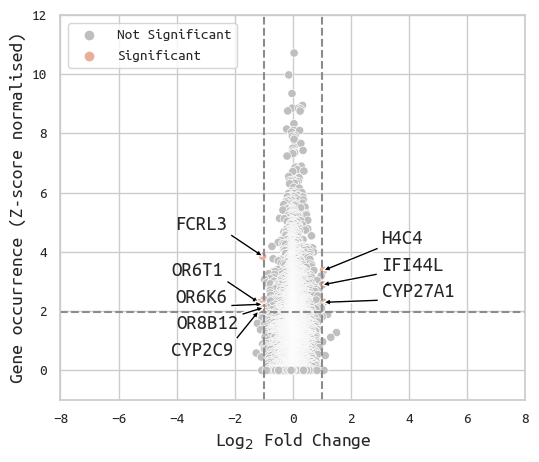

In [60]:
x, y, hue = ["diff_meth_promoters_logFC", "mean_z_score", "Statistical significance"]
meth_scatter_df = top_genes_df[[x, y]].dropna()

meth_scatter_df[hue] = "Significant"
meth_scatter_df.loc[meth_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
meth_scatter_df.loc[abs(meth_scatter_df[x]) < 1, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=meth_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] > 1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] < -1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 2, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 3, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel(r"Log$_2$ Fold Change", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4D_jointplot_diff_meth_prim_under.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4D_jointplot_diff_meth_prim_under.svg"),
    bbox_inches="tight",
)

### 4E. Jointplot of z-scores vs. log2 fold changes of DEGs (met over)

In [61]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)
print(top_genes_df.shape)

(40755, 17)


In [62]:
top_genes_df.to_excel(writer_3, sheet_name="3C. Top genes stats (MET over)")

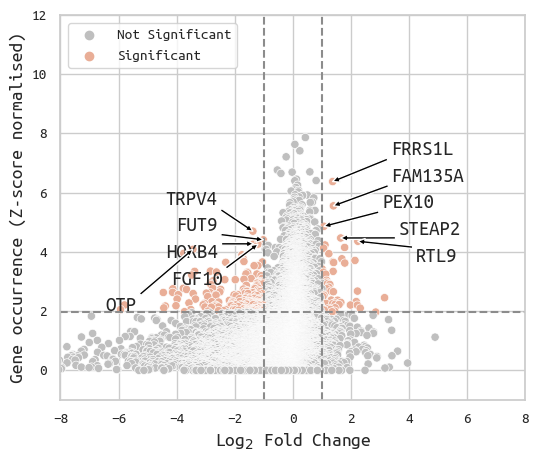

In [63]:
x, y, hue = ["diff_expr_log2FoldChange", "mean_z_score", "Statistical significance"]
expr_scatter_df = top_genes_df[[x, y]].dropna()

expr_scatter_df[hue] = "Significant"
expr_scatter_df.loc[expr_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
expr_scatter_df.loc[abs(expr_scatter_df[x]) < 1, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=expr_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] > 1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] < -1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 2, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 3, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel(r"Log$_2$ Fold Change", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4E_jointplot_diff_expr_met_over.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4E_jointplot_diff_expr_met_over.svg"),
    bbox_inches="tight",
)

### 4F. Jointplot of z-scores vs. log2 fold changes of DMRs (met over)

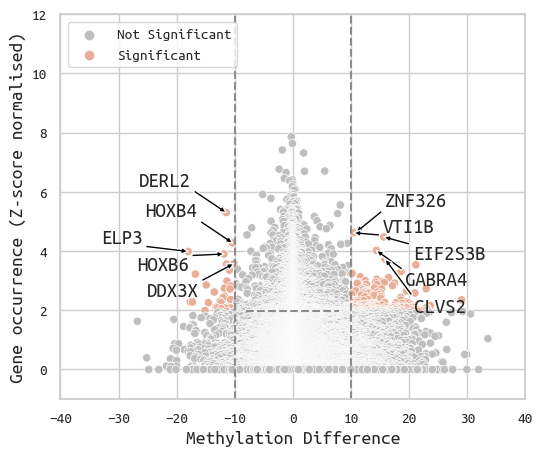

In [64]:
x, y, hue = [
    "diff_meth_promoters_meth.diff",
    "mean_z_score",
    "Statistical significance",
]
meth_scatter_df = top_genes_df[[x, y]].dropna()

meth_scatter_df[hue] = "Significant"
meth_scatter_df.loc[meth_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
meth_scatter_df.loc[abs(meth_scatter_df[x]) < 10, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=meth_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] > 1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] < -1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 5, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 15, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

plt.xlim(-40, 40)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(10, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-10, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel("Methylation Difference", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4F_jointplot_diff_meth_met_over.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4F_jointplot_diff_meth_met_over.svg"),
    bbox_inches="tight",
)

### 4G. Jointplot of z-scores vs. log2 fold changes of DEGs (met under)

In [65]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)
print(top_genes_df.shape)

(40755, 17)


In [66]:
top_genes_df.to_excel(writer_3, sheet_name="3D. Top genes stats (MET under)")

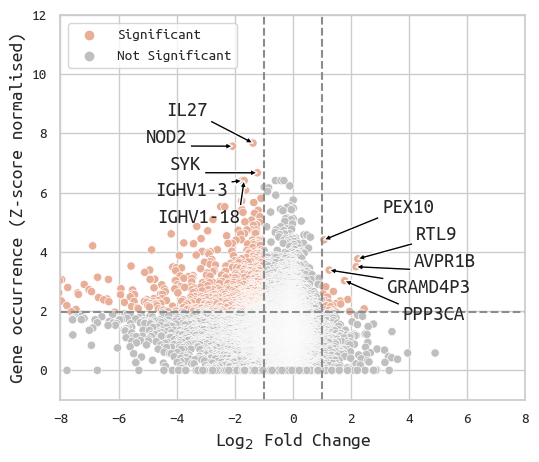

In [67]:
x, y, hue = ["diff_expr_log2FoldChange", "mean_z_score", "Statistical significance"]
expr_scatter_df = top_genes_df[[x, y]].dropna()

expr_scatter_df[hue] = "Significant"
expr_scatter_df.loc[expr_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
expr_scatter_df.loc[abs(expr_scatter_df[x]) < 1, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=expr_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] > 1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    expr_scatter_df.loc[
        (expr_scatter_df[x] < -1) & (expr_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 2, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 3, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-1, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel(r"Log$_2$ Fold Change", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4G_jointplot_diff_expr_met_under.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4G_jointplot_diff_expr_met_under.svg"),
    bbox_inches="tight",
)

### 4H. Jointplot of z-scores vs. log2 fold changes of DMRs (met under)

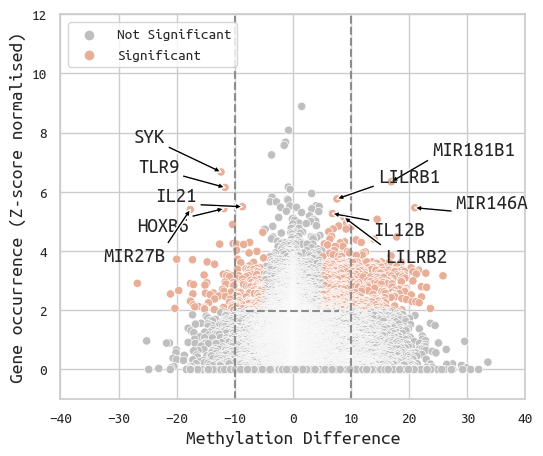

In [68]:
x, y, hue = [
    "diff_meth_promoters_meth.diff",
    "mean_z_score",
    "Statistical significance",
]
meth_scatter_df = top_genes_df[[x, y]].dropna()

meth_scatter_df[hue] = "Significant"
meth_scatter_df.loc[meth_scatter_df["mean_z_score"] < 1.96, hue] = "Not Significant"
meth_scatter_df.loc[abs(meth_scatter_df[x]) < 5, hue] = "Not Significant"

palette = {"Significant": "#E9AE97", "Not Significant": "#BFBFBF"}

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

grid = sns.scatterplot(data=meth_scatter_df, x=x, y=y, hue=hue, palette=palette, ax=ax)

top_up = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] > 1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)
top_down = (
    meth_scatter_df.loc[
        (meth_scatter_df[x] < -1) & (meth_scatter_df[hue] == "Significant")
    ]
    .sort_values(y, ascending=False)
    .head(5)
)

text_y = 99
for gene, gene_meta in top_up.iterrows():
    text_y_new = gene_meta[y] + 0.9
    text_y_new = (
        (text_y := text_y_new)
        if text_y - text_y_new > 0.9
        else (text_y := text_y - 0.9)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] + 7, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

text_y = 99
for gene, gene_meta in top_down.iterrows():
    text_y_new = gene_meta[y] + 1
    text_y_new = (
        (text_y := text_y_new) if text_y - text_y_new > 1 else (text_y := text_y - 1)
    )
    plt.annotate(
        gene,
        xy=(gene_meta[x], gene_meta[y]),
        xytext=(gene_meta[x] - 15, text_y_new),
        arrowprops=dict(facecolor="black", width=2, headwidth=5, headlength=5),
        fontsize=15,
    )

plt.xlim(-40, 40)
plt.ylim(ymin, ymax)
plt.legend(loc="upper left")
plt.vlines(10, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.vlines(-10, ymin=ymin, ymax=ymax, colors="#8C8C8C", linestyles="dashed")
plt.hlines(1.96, xmin=xmin, xmax=xmax, colors="#8C8C8C", linestyles="dashed")
plt.ylabel("Gene occurrence (Z-score normalised)", fontsize=14)
plt.xlabel("Methylation Difference", fontsize=14)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4H_jointplot_diff_meth_met_under.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("4H_jointplot_diff_meth_met_under.svg"),
    bbox_inches="tight",
)

In [69]:
writer_3.close()

In [70]:
# compute overlap between genes
prim_sheets = ["3A. Top genes stats (PRIM over)", "3B. Top genes stats (PRIM under)"]
met_sheets = ["3C. Top genes stats (MET over)", "3D. Top genes stats (MET under)"]

prim_genes = list()
met_genes = list()

for sheet in prim_sheets:
    df = pd.read_excel(
        pcta_wcdt_add_files_path / "supplementary_file_3.xlsx", sheet, index_col=0
    )
    df = df[df["p_value"] < 0.05]
    prim_genes.append(set(df.index))

print(len(prim_genes[0].intersection(prim_genes[1])))
print(len(prim_genes[0].union(prim_genes[1])))

for sheet in met_sheets:
    df = pd.read_excel(
        pcta_wcdt_add_files_path / "supplementary_file_3.xlsx", sheet, index_col=0
    )
    df = df[df["p_value"] < 0.05]
    met_genes.append(set(df.index))

print(len(met_genes[0].intersection(met_genes[1])))
print(len(met_genes[0].union(met_genes[1])))


3308
10514
1300
10196


## Figure 5: Functional profiling of PSMA protein community

1. (**A**) Barplot & Stripplots of ORA results for category H (prim over)
2. (**B**) Barplot & Stripplots of ORA results for category H (prim under)
3. (**C**) Barplot & Stripplots of ORA results for category H (met over)
4. (**D**) Barplot & Stripplots of ORA results for category H (met under)

In [71]:
writer_4 = pd.ExcelWriter(pcta_wcdt_add_files_path / "supplementary_file_4.xlsx")

In [72]:
ytick_length = 36

### 5A: Barplot & Stripplots of ORA results for category H (prim over)

In [73]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]

ora_h_file = (
    clustering_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(f"{psma_cluster_id}_ora_H.csv")
)

if ora_h_file.exists():
    ora_h_df = (
        pd.read_csv(ora_h_file, index_col=0)
        .drop(columns=["ID", "Description"])
        .sort_values("Count", ascending=False)
    )

ora_h_df.index = ora_h_df.index.str.replace("HALLMARK_", "").str.replace("_", " ")

In [74]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)

num_cols = ["mean_z_score", "diff_expr_log2FoldChange", "diff_meth_promoters_logFC"]
data_df = (
    ora_h_df["geneID"]
    .str.split("/")
    .explode()
    .rename("gene")
    .to_frame()
    .join(top_genes_df[num_cols], on="gene")
)

In [75]:
data_df.to_excel(writer_4, sheet_name="4A. ORA H Genes (PRIM over)")

/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119

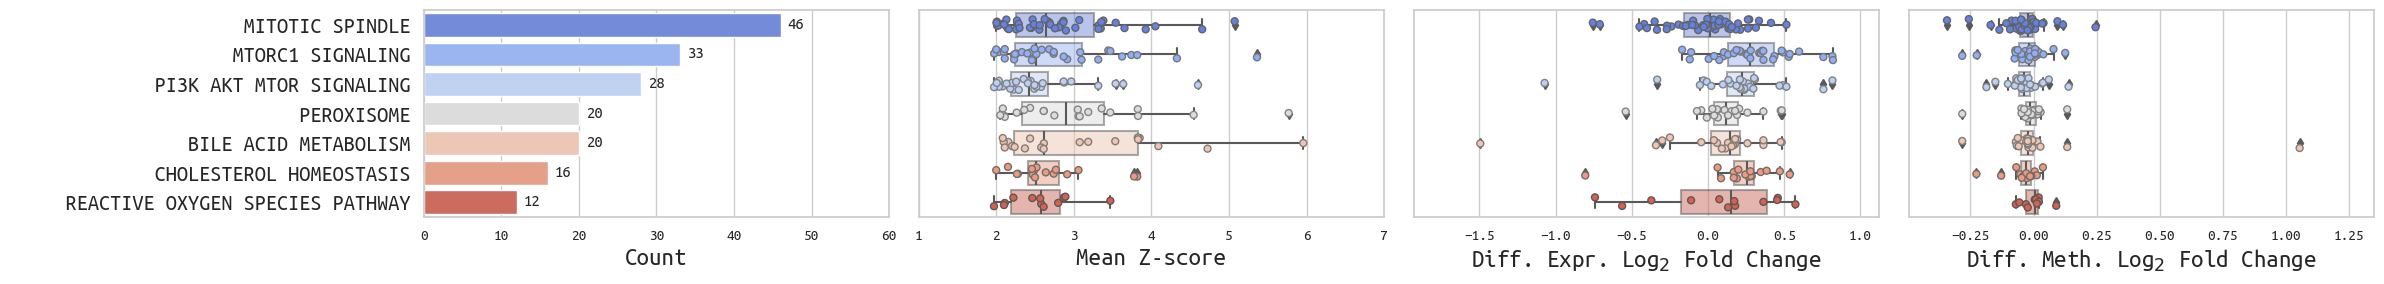

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(24, 3), dpi=100)

# 0. Count barplot
sns.barplot(data=ora_h_df, x="Count", y=ora_h_df.index, ax=ax[0], palette=PALETTE_STR)
for container in ax[0].containers:
    ax[0].bar_label(container, padding=5)

# ax[0].set_ylabel("Gene Sets", fontsize=14)
ax[0].set_xlabel("Count", fontsize=18)
ax[0].set_yticklabels(
    [
        " " * (ytick_length - len(gene_set)) + gene_set
        for gene_set in ora_h_df.index.tolist()
    ],
    fontsize=16,
)
ax[0].set_xlim([0, 60])

# 1. Mean Z-score stripplot
data_df_plot = deepcopy(data_df.dropna(subset=["mean_z_score"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    ax=ax[1],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    hue=data_df_plot.index,
    ax=ax[1],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[1].get_legend().remove()
ax[1].set_xlim([1, 7])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Mean Z-score", fontsize=18)

# 2. Diff. Expr. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_expr_log2FoldChange"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    ax=ax[2],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    hue=data_df_plot.index,
    ax=ax[2],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[2].get_legend().remove()
ax[2].set_xlim([ax[2].get_xlim()[0] * 1.2, ax[2].get_xlim()[1] * 1.2])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Diff. Expr. Log$_2$ Fold Change", fontsize=18)

# 3. Diff. Meth. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_meth_promoters_logFC"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_logFC",
    ax=ax[3],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_logFC",
    hue=data_df_plot.index,
    ax=ax[3],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[3].get_legend().remove()
ax[3].set_xlim([ax[3].get_xlim()[0] * 1.2, ax[3].get_xlim()[1] * 1.2])
ax[3].set_yticklabels([])
ax[3].set_xlabel("Diff. Meth. Log$_2$ Fold Change", fontsize=18)

plt.subplots_adjust(wspace=0.08, hspace=0)
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("5A_ora_h_prim_over.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("5A_ora_h_prim_over.svg"), bbox_inches="tight")

In [77]:
data_df[
    (abs(data_df["diff_expr_log2FoldChange"]) > 1)
    | (abs(data_df["diff_meth_promoters_logFC"]) > 1)
].sort_values("diff_expr_log2FoldChange", key=abs, ascending=False).drop_duplicates(
    "gene"
)

,gene,mean_z_score,diff_expr_log2FoldChange,diff_meth_promoters_logFC
BILE ACID METABOLISM,CYP27A1,2.203527,-1.494179,1.053926
PI3K AKT MTOR SIGNALING,CAMK4,2.443949,-1.072372,0.138485


### 5B: Barplot & Stripplots of ORA results for category H (prim under)

In [78]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]

ora_h_file = (
    clustering_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(f"{psma_cluster_id}_ora_H.csv")
)

if ora_h_file.exists():
    ora_h_df = (
        pd.read_csv(ora_h_file, index_col=0)
        .drop(columns=["ID", "Description"])
        .sort_values("Count", ascending=False)
    )

ora_h_df.index = ora_h_df.index.str.replace("HALLMARK_", "").str.replace("_", " ")

In [79]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)

num_cols = ["mean_z_score", "diff_expr_log2FoldChange", "diff_meth_promoters_logFC"]
data_df = (
    ora_h_df["geneID"]
    .str.split("/")
    .explode()
    .rename("gene")
    .to_frame()
    .join(top_genes_df[num_cols], on="gene")
)

In [80]:
data_df.to_excel(writer_4, sheet_name="4B. ORA H Genes (PRIM under)")

/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119

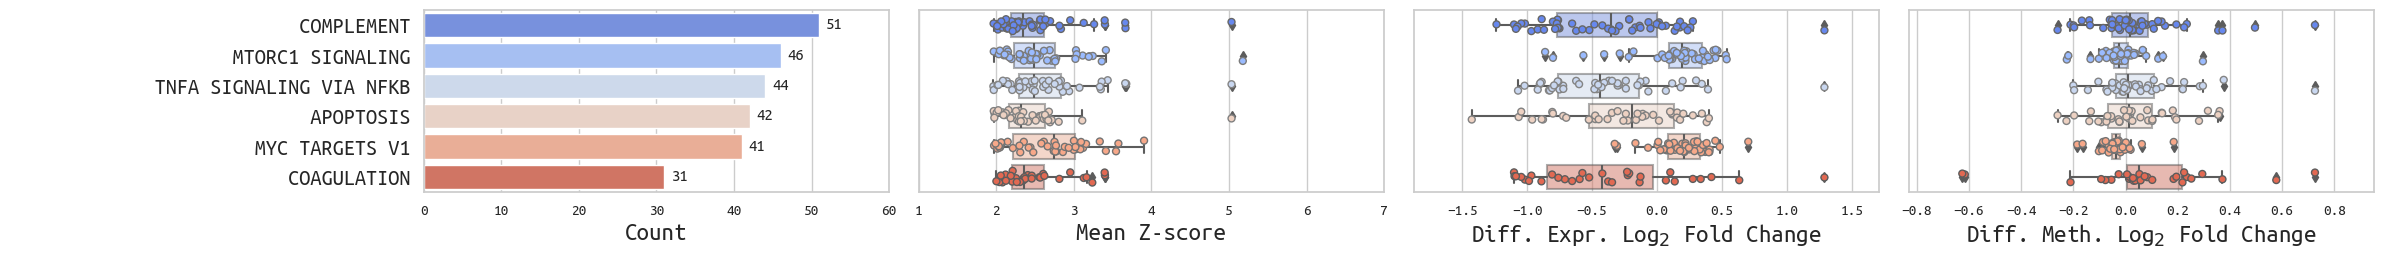

In [81]:
fig, ax = plt.subplots(1, 4, figsize=(24, 2.75), dpi=100)

# 0. Count barplot
sns.barplot(data=ora_h_df, x="Count", y=ora_h_df.index, ax=ax[0], palette=PALETTE_STR)
for container in ax[0].containers:
    ax[0].bar_label(container, padding=5)

ax[0].set_xlabel("Count", fontsize=18)
ax[0].set_yticklabels(
    [
        " " * (ytick_length - len(gene_set)) + gene_set
        for gene_set in ora_h_df.index.tolist()
    ],
    fontsize=16,
)
ax[0].set_xlim([0, 60])

# 1. Mean Z-score stripplot
data_df_plot = deepcopy(data_df.dropna(subset=["mean_z_score"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    ax=ax[1],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    hue=data_df_plot.index,
    ax=ax[1],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[1].get_legend().remove()
ax[1].set_xlim([1, 7])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Mean Z-score", fontsize=18)

# 2. Diff. Expr. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_expr_log2FoldChange"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    ax=ax[2],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    hue=data_df_plot.index,
    ax=ax[2],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[2].get_legend().remove()
ax[2].set_xlim([ax[2].get_xlim()[0] * 1.2, ax[2].get_xlim()[1] * 1.2])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Diff. Expr. Log$_2$ Fold Change", fontsize=18)

# 3. Diff. Meth. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_meth_promoters_logFC"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_logFC",
    ax=ax[3],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_logFC",
    hue=data_df_plot.index,
    ax=ax[3],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[3].get_legend().remove()
ax[3].set_xlim([ax[3].get_xlim()[0] * 1.2, ax[3].get_xlim()[1] * 1.2])
ax[3].set_yticklabels([])
ax[3].set_xlabel("Diff. Meth. Log$_2$ Fold Change", fontsize=18)

plt.subplots_adjust(wspace=0.08, hspace=0)
plt.tight_layout()
plt.savefig(
    pcta_wcdt_figs_path.joinpath("5B_ora_h_prim_under.pdf"), bbox_inches="tight"
)
plt.savefig(
    pcta_wcdt_figs_path.joinpath("5B_ora_h_prim_under.svg"), bbox_inches="tight"
)

In [82]:
data_df[
    (abs(data_df["diff_expr_log2FoldChange"]) > 1)
    | (abs(data_df["diff_meth_promoters_logFC"]) > 1)
].sort_values("diff_expr_log2FoldChange", key=abs, ascending=False).drop_duplicates(
    "gene"
)

,gene,mean_z_score,diff_expr_log2FoldChange,diff_meth_promoters_logFC
APOPTOSIS,IGFBP6,2.715013,-1.424930,0.189800
COAGULATION,F3,2.605755,1.288074,0.224464
COMPLEMENT,APOBEC3G,2.135528,-1.234678,NaN
COMPLEMENT,C1S,3.128226,-1.099811,0.234897
COAGULATION,CFI,2.041725,-1.096063,NaN
COAGULATION,SERPING1,3.397717,-1.085190,0.371506
COMPLEMENT,GNG2,2.251314,-1.072542,-0.199147
TNFA SIGNALING VIA NFKB,GFPT2,2.293127,-1.068982,0.036024
APOPTOSIS,CAV1,2.596863,-1.064238,0.360575
APOPTOSIS,CLU,2.254834,-1.044379,0.102350


### 5C: Barplot & Stripplots of ORA results for category H (met over)

In [83]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]

ora_h_file = (
    clustering_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(f"{psma_cluster_id}_ora_H.csv")
)

if ora_h_file.exists():
    ora_h_df = (
        pd.read_csv(ora_h_file, index_col=0)
        .drop(columns=["ID", "Description"])
        .sort_values("Count", ascending=False)
    )

ora_h_df.index = ora_h_df.index.str.replace("HALLMARK_", "").str.replace("_", " ")

In [84]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)

num_cols = ["mean_z_score", "diff_expr_log2FoldChange", "diff_meth_promoters_meth.diff"]
data_df = (
    ora_h_df["geneID"]
    .str.split("/")
    .explode()
    .rename("gene")
    .to_frame()
    .join(top_genes_df[num_cols], on="gene")
)

In [85]:
data_df.to_excel(writer_4, sheet_name="4C. ORA H Genes (MET over)")

/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119

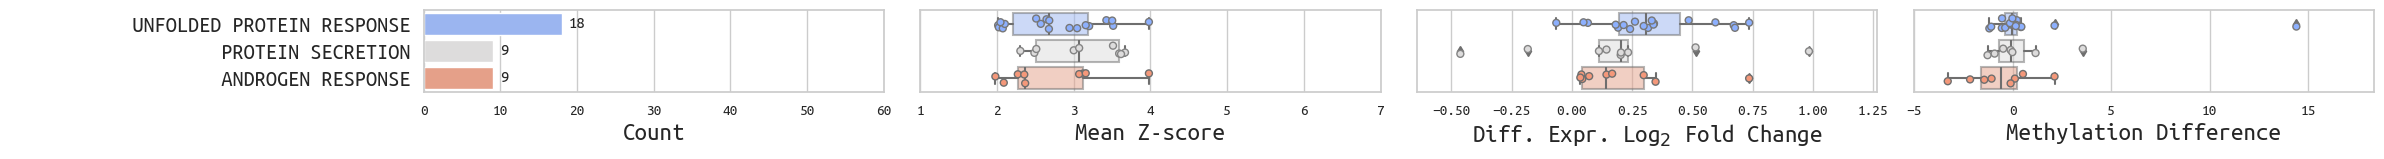

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(24, 1.75), dpi=100)

# 0. Count barplot
sns.barplot(data=ora_h_df, x="Count", y=ora_h_df.index, ax=ax[0], palette=PALETTE_STR)
for container in ax[0].containers:
    ax[0].bar_label(container, padding=5)

ax[0].set_xlabel("Count", fontsize=18)
ax[0].set_yticklabels(
    [
        " " * (ytick_length - len(gene_set)) + gene_set
        for gene_set in ora_h_df.index.tolist()
    ],
    fontsize=16,
)
ax[0].set_xlim([0, 60])

# 1. Mean Z-score stripplot
data_df_plot = deepcopy(data_df.dropna(subset=["mean_z_score"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    ax=ax[1],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    hue=data_df_plot.index,
    ax=ax[1],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[1].get_legend().remove()
ax[1].set_xlim([1, 7])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Mean Z-score", fontsize=18)

# 2. Diff. Expr. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_expr_log2FoldChange"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    ax=ax[2],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    hue=data_df_plot.index,
    ax=ax[2],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[2].get_legend().remove()
ax[2].set_xlim([ax[2].get_xlim()[0] * 1.2, ax[2].get_xlim()[1] * 1.2])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Diff. Expr. Log$_2$ Fold Change", fontsize=18)

# 3. Diff. Meth. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_meth_promoters_meth.diff"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_meth.diff",
    ax=ax[3],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_meth.diff",
    hue=data_df_plot.index,
    ax=ax[3],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[3].get_legend().remove()
ax[3].set_xlim([ax[3].get_xlim()[0] * 1.2, ax[3].get_xlim()[1] * 1.2])
ax[3].set_yticklabels([])
ax[3].set_xlabel("Methylation Difference", fontsize=18)

plt.subplots_adjust(wspace=0.08, hspace=0)
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("5C_ora_h_met_over.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("5C_ora_h_met_over.svg"), bbox_inches="tight")

In [87]:
data_df[
    (abs(data_df["diff_expr_log2FoldChange"]) > 1)
    | (abs(data_df["diff_meth_promoters_meth.diff"]) > 10)
].sort_values("diff_expr_log2FoldChange", key=abs, ascending=False).drop_duplicates(
    "gene"
)

,gene,mean_z_score,diff_expr_log2FoldChange,diff_meth_promoters_meth.diff
UNFOLDED PROTEIN RESPONSE,SSR1,3.043634,0.331467,14.401755


### 5D: Barplot & Stripplots of ORA results for category H (met under)

In [88]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]

ora_h_file = (
    clustering_root.joinpath("functional")
    .joinpath("MSIGDB")
    .joinpath(f"{psma_cluster_id}_ora_H.csv")
)

if ora_h_file.exists():
    ora_h_df = (
        pd.read_csv(ora_h_file, index_col=0)
        .drop(columns=["ID", "Description"])
        .sort_values("Count", ascending=False)
    )

ora_h_df.index = ora_h_df.index.str.replace("HALLMARK_", "").str.replace("_", " ")

In [89]:
top_genes_df = pd.read_csv(
    pcta_wcdt_root.joinpath("degss_genes_stats")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("gene_occurrence_stats_bootstrap_z_score_summary_ann.csv"),
    index_col=0,
)

num_cols = ["mean_z_score", "diff_expr_log2FoldChange", "diff_meth_promoters_meth.diff"]
data_df = (
    ora_h_df["geneID"]
    .str.split("/")
    .explode()
    .rename("gene")
    .to_frame()
    .join(top_genes_df[num_cols], on="gene")
)

In [90]:
data_df.to_excel(writer_4, sheet_name="4D. ORA H Genes (MET under)")

/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uziel/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119

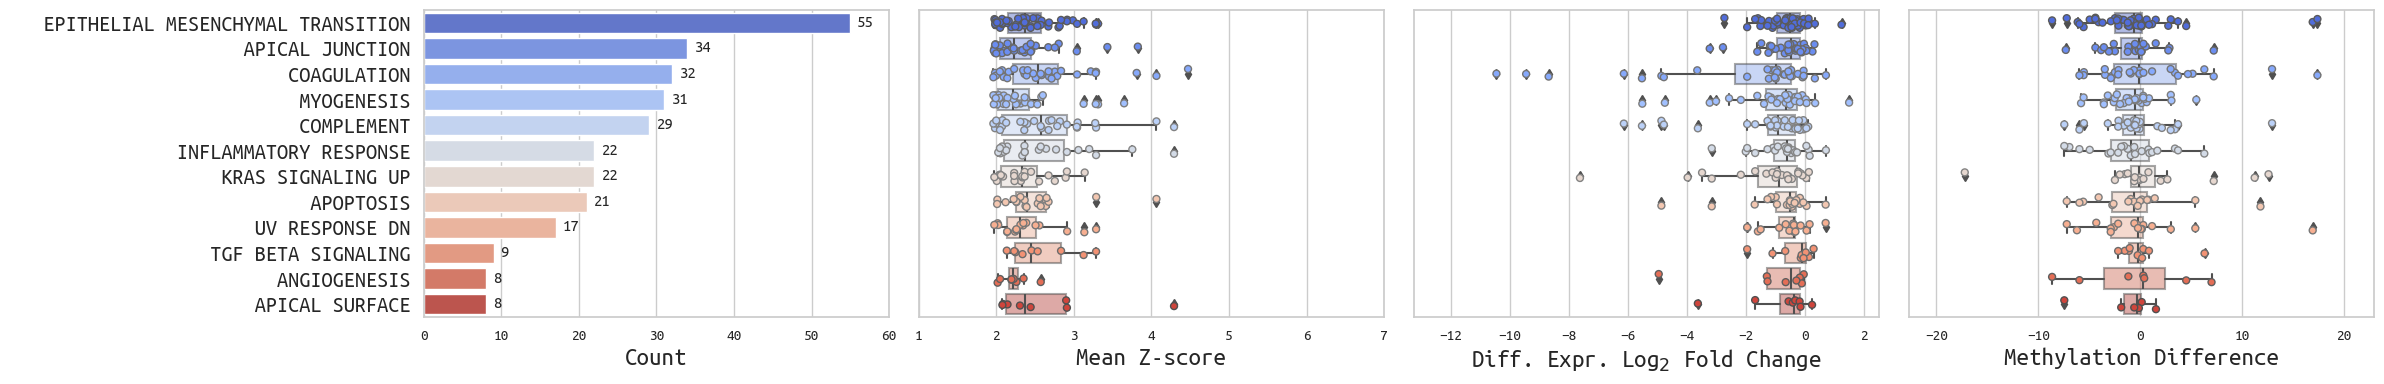

In [91]:
fig, ax = plt.subplots(1, 4, figsize=(24, 4), dpi=100)

# 0. Count barplot
sns.barplot(data=ora_h_df, x="Count", y=ora_h_df.index, ax=ax[0], palette=PALETTE_STR)
for container in ax[0].containers:
    ax[0].bar_label(container, padding=5)

ax[0].set_xlabel("Count", fontsize=18)
ax[0].set_yticklabels(
    [
        " " * (ytick_length - len(gene_set)) + gene_set
        for gene_set in ora_h_df.index.tolist()
    ],
    fontsize=16,
)
ax[0].set_xlim([0, 60])

# 1. Mean Z-score stripplot
data_df_plot = deepcopy(data_df.dropna(subset=["mean_z_score"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    ax=ax[1],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="mean_z_score",
    hue=data_df_plot.index,
    ax=ax[1],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[1].get_legend().remove()
ax[1].set_xlim([1, 7])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Mean Z-score", fontsize=18)

# 2. Diff. Expr. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_expr_log2FoldChange"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    ax=ax[2],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_expr_log2FoldChange",
    hue=data_df_plot.index,
    ax=ax[2],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[2].get_legend().remove()
ax[2].set_xlim([ax[2].get_xlim()[0] * 1.2, ax[2].get_xlim()[1] * 1.2])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Diff. Expr. Log$_2$ Fold Change", fontsize=18)

# 3. Diff. Meth. LFC
data_df_plot = deepcopy(data_df.dropna(subset=["diff_meth_promoters_meth.diff"]))
sns.boxplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_meth.diff",
    ax=ax[3],
    palette=PALETTE_STR,
    boxprops=dict(alpha=0.5),
)
sns.stripplot(
    data=data_df_plot,
    y=data_df_plot.index,
    x="diff_meth_promoters_meth.diff",
    hue=data_df_plot.index,
    ax=ax[3],
    palette=PALETTE_STR,
    marker="o",
    linewidth=1,
    jitter=0.2,
)
ax[3].get_legend().remove()
ax[3].set_xlim([ax[3].get_xlim()[0] * 1.2, ax[3].get_xlim()[1] * 1.2])
ax[3].set_yticklabels([])
ax[3].set_xlabel("Methylation Difference", fontsize=18)

plt.subplots_adjust(wspace=0.08, hspace=0)
plt.tight_layout()
plt.savefig(pcta_wcdt_figs_path.joinpath("5D_ora_h_met_under.pdf"), bbox_inches="tight")
plt.savefig(pcta_wcdt_figs_path.joinpath("5D_ora_h_met_under.svg"), bbox_inches="tight")

In [92]:
data_df[
    (abs(data_df["diff_expr_log2FoldChange"]) > 1)
    | (abs(data_df["diff_meth_promoters_meth.diff"]) > 10)
].sort_values("diff_expr_log2FoldChange", key=abs, ascending=False).drop_duplicates(
    "gene"
)

,gene,mean_z_score,diff_expr_log2FoldChange,diff_meth_promoters_meth.diff
COAGULATION,FGA,3.810032,-10.446974,5.135064
COAGULATION,FGG,3.218959,-9.442341,4.671418
COAGULATION,APOA1,4.472469,-8.680531,-3.456491
KRAS SIGNALING UP,NR0B2,1.975793,-7.620517,NaN
COAGULATION,HNF4A,1.963298,-6.134790,2.981501
COAGULATION,SERPINA1,2.713258,-5.521085,-5.529064
MYOGENESIS,CKM,2.581638,-5.509113,NaN
ANGIOGENESIS,VTN,2.196929,-4.953607,6.990202
COAGULATION,F2,4.065165,-4.863093,-0.931516
COMPLEMENT,PLG,2.786589,-4.779860,12.924868


In [93]:
writer_4.close()

## Additional information and figures

### Table 1: Enriched gene sets from different methods

#### Primary

In [94]:
prim_dgsva_files = sorted(
    list(
        pcta_wcdt_root.joinpath("diff_gsva").glob(
            "**/*prim_high_vs_prim_low_top_table_padj_0_05_up_0_0.csv"
        )
    )
    + list(
        pcta_wcdt_root.joinpath("diff_gsva").glob(
            "**/*prim_high_vs_prim_low_top_table_padj_0_05_down_0_0.csv"
        )
    )
)

prim_dgsva_counts = dict()
for dgsva_file in prim_dgsva_files:
    msigdb_cat = dgsva_file.parent.stem
    lfc_level = (
        "under-enriched"
        if dgsva_file.stem.split("_")[-3] == "down"
        else "over-enriched"
    )
    prim_dgsva_counts[(msigdb_cat, lfc_level)] = len(
        pd.read_csv(dgsva_file, index_col=0)
    )

In [95]:
prim_gsea_de = sorted(
    pcta_wcdt_root.joinpath("functional")
    .joinpath("MSIGDB")
    .glob("*_prim_high_vs_prim_low_gsea_*.csv")
)

prim_gsea_de_counts = dict()
for gsea_file in prim_gsea_de:
    msigdb_cat = gsea_file.stem.split("_")[-1]
    df = pd.read_csv(gsea_file, index_col=0)
    prim_gsea_de_counts[(msigdb_cat, "over-enriched")] = len(
        df[df["enrichmentScore"] > 0]
    )
    prim_gsea_de_counts[(msigdb_cat, "under-enriched")] = len(
        df[df["enrichmentScore"] < 0]
    )

In [96]:
prim_gsea_dm = sorted(
    tcga_root.joinpath("functional")
    .joinpath("MSIGDB")
    .glob("*_prim_high_vs_prim_low_wrt_mean_diff_0_0_hg38_genes_promoters_gsea_*.csv")
)

prim_gsea_dm_counts = dict()
for gsea_file in prim_gsea_dm:
    msigdb_cat = gsea_file.stem.split("_")[-1]
    df = pd.read_csv(gsea_file, index_col=0)
    prim_gsea_dm_counts[(msigdb_cat, "over-enriched")] = len(
        df[df["enrichmentScore"] > 0]
    )
    prim_gsea_dm_counts[(msigdb_cat, "under-enriched")] = len(
        df[df["enrichmentScore"] < 0]
    )

#### Metastatic

In [97]:
met_dgsva_files = sorted(
    list(
        pcta_wcdt_root.joinpath("diff_gsva").glob(
            "**/*met_high_vs_met_low_top_table_padj_0_05_up_0_0.csv"
        )
    )
    + list(
        pcta_wcdt_root.joinpath("diff_gsva").glob(
            "**/*met_high_vs_met_low_top_table_padj_0_05_down_0_0.csv"
        )
    )
)

met_dgsva_counts = dict()
for dgsva_file in met_dgsva_files:
    msigdb_cat = dgsva_file.parent.stem
    lfc_level = (
        "under-enriched"
        if dgsva_file.stem.split("_")[-3] == "down"
        else "over-enriched"
    )
    met_dgsva_counts[(msigdb_cat, lfc_level)] = len(
        pd.read_csv(dgsva_file, index_col=0)
    )

In [98]:
met_gsea_de = sorted(
    pcta_wcdt_root.joinpath("functional")
    .joinpath("MSIGDB")
    .glob("*_met_high_vs_met_low_gsea_*.csv")
)

met_gsea_de_counts = dict()
for gsea_file in met_gsea_de:
    msigdb_cat = gsea_file.stem.split("_")[-1]
    df = pd.read_csv(gsea_file, index_col=0)
    met_gsea_de_counts[(msigdb_cat, "over-enriched")] = len(
        df[df["enrichmentScore"] > 0]
    )
    met_gsea_de_counts[(msigdb_cat, "under-enriched")] = len(
        df[df["enrichmentScore"] < 0]
    )

In [99]:
met_gsea_dm = sorted(
    wcdt_root.joinpath("methylkit")
    .joinpath("functional")
    .joinpath("MSIGDB")
    .glob("*_met_high_vs_met_low_ann_genes_hg38_genes_promoters_gsea_*.csv")
)

met_gsea_dm_counts = dict()
for gsea_file in met_gsea_dm:
    msigdb_cat = gsea_file.stem.split("_")[-1]
    df = pd.read_csv(gsea_file, index_col=0)
    met_gsea_dm_counts[(msigdb_cat, "over-enriched")] = len(
        df[df["enrichmentScore"] > 0]
    )
    met_gsea_dm_counts[(msigdb_cat, "under-enriched")] = len(
        df[df["enrichmentScore"] < 0]
    )

#### Build table

In [100]:
table_2_df = (
    pd.DataFrame(
        {
            ("Prim high/low", "DGSVA"): prim_dgsva_counts,
            ("Prim high/low", "GSEA DE"): prim_gsea_de_counts,
            ("Prim high/low", "GSEA DM"): prim_gsea_dm_counts,
            ("Met high/low", "DGSVA"): met_dgsva_counts,
            ("Met high/low", "GSEA DE"): met_gsea_de_counts,
            ("Met high/low", "GSEA DM"): met_gsea_dm_counts,
        }
    )
    .fillna(0)
    .astype(int)
)
table_2_df.index.set_names(["MSigDB Category", "Enrichment Level"], inplace=True)
table_2_df.to_csv(pcta_wcdt_add_files_path / "table_2.csv")
table_2_df

Prim high/low                 Met high/low  \
                                         DGSVA GSEA DE GSEA DM        DGSVA   
MSigDB Category Enrichment Level                                              
C1              under-enriched              83       7       6           14   
                over-enriched               70       3       4           38   
C2              under-enriched            2265     472      24         1945   
                over-enriched             2396     208     362          622   
C3              under-enriched             519      35       2          283   
                over-enriched             1122       4     122         1379   
C4              under-enriched             335     174      29          348   
                over-enriched              406     109      59          128   
C5              under-enriched            5187     815      22         3566   
                over-enriched             6066     160     266         1793   
C6              under-enriched             124      61       0          124   
                over-enriched               31       0      50           10   
C7              under-enriched            1424     143       0         1166   
                over-enriched             2368       0     168          661   
C8              under-enriched             440     218       3          252   
                over-enriched               96      10     154           46   
H               under-enriched              18      12       1           20   
                over-enriched               22       5      14            4   

                                                  
                                 GSEA DE GSEA DM  
MSigDB Category Enrichment Level                  
C1              under-enriched         6       4  
                over-enriched          0      10  
C2              under-enriched       391       4  
                over-enriched         16       4  
C3              under-enriched        10       0  
                over-enriched          0       0  
C4              under-enriched       205       1  
                over-enriched          9       0  
C5              under-enriched       535       0  
                over-enriched         16       6  
C6              under-enriched        80       4  
                over-enriched          0       0  
C7              under-enriched       131       0  
                over-enriched          0       0  
C8              under-enriched       182       2  
                over-enriched          0       2  
H               under-enriched        11       0  
                over-enriched          0       0

In [101]:
table_2_df.to_latex(
    pcta_wcdt_add_files_path / "table_2.tex",
    bold_rows=True,
    caption="Number of (differentially) enriched gene sets for each MSigDB category and enrichment method.",
    label="table2",
)

### Table 2: Cluster sizes

In [102]:
writer_3 = pd.ExcelWriter(pcta_wcdt_add_files_path / "supplementary_file_3.xlsx")

In [103]:
cluster_sizes = dict()

#### Prim over

In [104]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]
print("Cluster ID FOLH1 is in:", psma_cluster_id)

Cluster ID FOLH1 is in: 4


In [105]:
clusters_df.to_excel(writer_3, sheet_name="3E. PPI Clustering (PRIM over)")

In [106]:
cluster_sizes["prim_over"] = (
    clusters_df.groupby("cluster_id")["FOLH1_distance"].count().to_dict()
)

#### Prim under

In [107]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "prim_high_vs_prim_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]
print("Cluster ID FOLH1 is in:", psma_cluster_id)

Cluster ID FOLH1 is in: 0


In [108]:
clusters_df.to_excel(writer_3, sheet_name="3F. PPI Clustering (PRIM under)")

In [109]:
cluster_sizes["prim_under"] = (
    clusters_df.groupby("cluster_id")["FOLH1_distance"].count().to_dict()
)

#### Met over

In [110]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_up_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]
print("Cluster ID FOLH1 is in:", psma_cluster_id)

Cluster ID FOLH1 is in: 0


In [111]:
clusters_df.to_excel(writer_3, sheet_name="3G. PPI Clustering (MET over)")

In [112]:
cluster_sizes["met_over"] = (
    clusters_df.groupby("cluster_id")["FOLH1_distance"].count().to_dict()
)

#### Met under

In [113]:
clustering_root = (
    pcta_wcdt_root.joinpath("degss_ppi_networks")
    .joinpath(
        "met_high_vs_met_low_degss_padj_0_05_down_0_0_"
        "gsea_H_C1_C2_C3_C4_C5_C6_C7_C8_union"
    )
    .joinpath("functional_network_at_500_score")
    .joinpath("clustering")
    .joinpath("p_1_0_q_0_5")
)

clusters_df = pd.read_csv(
    clustering_root.joinpath("genes_cluster_ids_metadata.csv"), index_col=0
).sort_values("cluster_id", ascending=True)
psma_cluster_id = clusters_df.loc["FOLH1"]["cluster_id"]
print("Cluster ID FOLH1 is in:", psma_cluster_id)

Cluster ID FOLH1 is in: 7


In [114]:
clusters_df.to_excel(writer_3, sheet_name="3H. PPI Clustering (MET under)")
writer_3.close()

In [115]:
cluster_sizes["met_under"] = (
    clusters_df.groupby("cluster_id")["FOLH1_distance"].count().to_dict()
)

#### Build table

In [116]:
cluster_sizes_df = (
    pd.DataFrame(cluster_sizes).fillna(0).astype(int).rename_axis("Cluster ID")
)
cluster_sizes_df.to_csv(pcta_wcdt_add_files_path / "table_3.csv")
cluster_sizes_df

,prim_over,prim_under,met_over,met_under
Cluster ID,,,,
0,794,2425,936,538
1,1172,469,35,17
2,901,532,93,164
3,1483,992,116,180
4,1936,535,360,516
5,0,494,275,452
6,0,0,489,498
7,0,0,331,783
8,0,0,415,125


In [117]:
cluster_sizes_df.to_latex(
    pcta_wcdt_add_files_path / "table_3.tex",
    bold_rows=True,
    caption="Size of clusters after ensemble clustering using Node2Vec embeddings.",
    label="table3",
)

### How many genes have both hypo- and hyper-methylated CpGs?

#### Primary

In [118]:
diff_meth_df = (
    pd.read_csv(
        (
            tcga_root.joinpath("minfi").joinpath(
                "sample_type_prim_FOLH1_level_prim_high+prim_low__"
                "diff_meth_probes_noob_quantile_top_table_prim_high_vs_prim_low_"
                "wrt_mean_diff_0_0_hg38_genes_promoters.csv"
            )
        ),
        index_col=0,
    )
    .replace("NA_character_", np.nan)
    .dropna(subset=["annot.symbol"])
)

hypo_hyper_meth_counts = (
    diff_meth_df.groupby("annot.symbol")["logFC"]
    .apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()]))
    .unstack()
    .rename(columns={0: "Hypo-methylated", 1: "Hyper-methylated"})
)

n_homogeneous = hypo_hyper_meth_counts[
    (hypo_hyper_meth_counts["Hypo-methylated"] == 0)
    | (hypo_hyper_meth_counts["Hyper-methylated"] == 0)
]
print("Number of genes with only hypo or hyper methylated CpGs:", len(n_homogeneous))
print(
    "Number of genes with both hypo or hyper methylated CpGs:",
    len(hypo_hyper_meth_counts) - len(n_homogeneous),
)

Number of genes with only hypo or hyper methylated CpGs: 7182
Number of genes with both hypo or hyper methylated CpGs: 13994


#### Metastatic

In [119]:
diff_meth_df = (
    pd.read_csv(
        (
            wcdt_root.joinpath("methylkit").joinpath(
                "sample_type_met_FOLH1_level_met_high+met_low__"
                "diff_meth_met_high_vs_met_low_ann_genes_hg38_genes_promoters.csv"
            )
        ),
        index_col=0,
    )
    .replace("NA_character_", np.nan)
    .dropna(subset=["annot.symbol"])
)

hypo_hyper_meth_counts = (
    diff_meth_df.groupby("annot.symbol")["meth.diff"]
    .apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()]))
    .unstack()
    .rename(columns={0: "Hypo-methylated", 1: "Hyper-methylated"})
)

n_homogeneous = hypo_hyper_meth_counts[
    (hypo_hyper_meth_counts["Hypo-methylated"] == 0)
    | (hypo_hyper_meth_counts["Hyper-methylated"] == 0)
]
print("Number of genes with only hypo or hyper methylated CpGs:", len(n_homogeneous))
print(
    "Number of genes with both hypo or hyper methylated CpGs:",
    len(hypo_hyper_meth_counts) - len(n_homogeneous),
)

Number of genes with only hypo or hyper methylated CpGs: 6752
Number of genes with both hypo or hyper methylated CpGs: 17564


In [120]:
diff_meth_df["annot.symbol"].nunique()

24316